In [1]:
import pandas as pd
import numpy as np
import spacy
import nltk
import string
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

## Loading data

In [2]:
df = pd.read_csv('england_recent.csv')

In [3]:
df.head()

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons,year
0,AFH-Wealth-Management,2015-12-11,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",2,3.0,1.0,NaN,2.0,1.0,4.0,x,o,r,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,2015
1,AFH-Wealth-Management,2016-01-28,Office Administrator,"Current Employee, less than 1 year","Bromsgrove, England, England",1,1.0,1.0,NaN,1.0,1.0,1.0,x,o,x,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",2016
2,AFH-Wealth-Management,2016-04-23,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",1,2.0,1.0,NaN,2.0,1.0,1.0,x,o,x,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...",2016
3,AFH-Wealth-Management,2016-09-23,IFA,Former Employee,"Bromsgrove, England, England",1,1.0,1.0,NaN,1.0,1.0,1.0,x,o,r,It horrible management,Good investment management strategy. Overall t...,The management and seniors are ruthless. No tr...,2016
4,AFH-Wealth-Management,2017-05-21,Administrative Support,"Former Employee, more than 5 years","Birmingham, England, England",1,4.0,1.0,NaN,2.0,4.0,1.0,o,v,v,Administration team,Free parking . Meet some nice people in the te...,Not treated at all well after 6 yrs of being a...,2017


In [4]:
df['firm'] = df['firm'].str.replace('-', ' ')
# Load the suggestion list
suggestion_df = pd.read_csv("Refined_Industry_and_Suggestion_List.csv")

# Filter for rows where suggestion is "remove"
firms_to_remove = suggestion_df[suggestion_df["suggestion"] == "remove"]["firm"].dropna().unique()

# Filter the main DataFrame
df = df[~df["firm"].isin(firms_to_remove)]

dffirms = df.groupby('firm').size().reset_index(name='Count')

df.to_csv('filtered_england_recent.csv')

In [5]:
#checking filter
df[df['firm'] == 'Tesco']

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons,year


## sample 10% of data, preprocess (lematization, no stopwords removal!)

In [6]:
from tqdm.notebook import tqdm
tqdm.pandas()

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Sample 1% of the data 
df_sample = df.sample(frac=0.1, random_state=21).copy()
#df_sample = df.copy()

#only lematizing, want to keep as many words as possible. 
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    doc = nlp(text.lower())
    return " ".join(token.lemma_ for token in doc if not token.is_punct and not token.is_space)


# Apply preprocessing with progress bar
for col in ['pros', 'cons']:
    print(f"Processing column: {col}")
    df_sample[f'{col}_clean'] = df_sample[col].progress_apply(preprocess_text)

# Preview result
df_sample[['pros_clean', 'cons_clean']].head()

Processing column: pros


  0%|          | 0/8943 [00:00<?, ?it/s]

Processing column: cons


  0%|          | 0/8943 [00:00<?, ?it/s]

,pros_clean,cons_clean
103357,through all the uncertainty recently the busin...,nothing to report on con
93254,10 year enough of work,do not learn anything and some staff get the p...
79636,none terrible place do not go there,terrible place to work do not go there
99553,great people the open plan culture mean that e...,as it be such a big company process can slow d...
10154,holiday flexibility staff discount colleague c...,management h r back stab lack of professionali...


In [7]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

## Getting rid of the ultra long reviews as they are hard to tokenize

In [8]:
def is_too_long(text, max_tokens=300):
    try:
        prompt = f"Sentiment toward 'placeholder': {text.strip()}"
        tokens = tokenizer(prompt, return_tensors="pt", truncation=False)
        return tokens["input_ids"].shape[1] > max_tokens
    except:
        return True  # Skip anything that breaks

df_sample['too_long_pro'] = df_sample['pros'].apply(lambda x: is_too_long(x, max_tokens=300))
df_sample['too_long_con'] = df_sample['cons'].apply(lambda x: is_too_long(x, max_tokens=300))

# Filter them out
df_sample = df_sample[~(df_sample['too_long_pro'] | df_sample['too_long_con'])]


Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors


## Moving to ASBA analysis

In [9]:
def get_aspect_sentiment(text, aspect, tone):
    if pd.isnull(text):
        return None

    # Compose prompt-like input for aspect analysis
    if tone == 'pos':
        combined = f"The following is a positive experience about {aspect}: {text}"
    else:
        combined = f"The following is a negative experience about {aspect}: {text}"

    inputs = tokenizer(combined, return_tensors="pt", truncation=True, max_length=512)

    with torch.no_grad():
        logits = model(**inputs).logits
    scores = softmax(logits.numpy()[0])

    # This model returns scores for: [1 star, 2 stars, 3 stars, 4 stars, 5 stars]
    star_labels = [1, 2, 3, 4, 5]
    result = dict(zip(star_labels, scores))
    result["label"] = star_labels[scores.argmax()]
    return result


In [10]:
df_sample = df_sample[
    (df_sample['pros_clean'].str.strip() != '') & (df_sample['cons_clean'].str.strip() != '')
]
print("Empty pros_clean:", (df_sample['pros_clean'].str.strip() == '').sum())
print("Empty cons_clean:", (df_sample['cons_clean'].str.strip() == '').sum())


Empty pros_clean: 0
Empty cons_clean: 0


In [14]:
from collections import Counter
failed_sentiment = Counter()

def analyze_all_aspect_groups(text, aspect_groups, tone):
    results = {}
    for aspect, keywords in aspect_groups.items():
        if any(kw in text.lower() for kw in keywords):
            sent = get_aspect_sentiment(text, aspect, tone)
            if sent:
                results[aspect] = sent
            else:
                failed_sentiment[aspect] += 1  # Track failures
    return results


## Adding marie's dynamic aspect detection

In [14]:
from pyabsa import ATEPCCheckpointManager

# Load ABSA model
aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(
    checkpoint='english',
    auto_device=True
)

# Clean for ABSA
def clean_min(text):
    if not isinstance(text, str):
        return ""
    return text.replace('\n', ' ').replace('\r', '').encode("ascii", errors="ignore").decode().strip()

df_sample['min_prep_pros'] = df_sample['pros'].apply(clean_min)
df_sample['min_prep_cons'] = df_sample['cons'].apply(clean_min)

# Sample for ABSA (adjust size as needed)
texts_pros = df_sample['min_prep_pros'].dropna().sample(frac=0.1, random_state=42).tolist()
texts_cons = df_sample['min_prep_cons'].dropna().sample(frac=0.1, random_state=42).tolist()

# Extract aspects from pros and cons
absa_results_pros = aspect_extractor.extract_aspect(inference_source=texts_pros, print_result=False)
absa_results_cons = aspect_extractor.extract_aspect(inference_source=texts_cons, print_result=False)

# Collect discovered aspects
from collections import Counter

aspect_counter = Counter()
for result in absa_results_pros + absa_results_cons:
    for asp in result.get("aspect", []):
        aspect_counter[asp.lower()] += 1

# Show top discovered aspects
top_aspects = [asp for asp, count in aspect_counter.items() if count >= 3]
print(f"Top discovered aspects: {top_aspects}")


[2025-04-21 13:51:34] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2025-04-21 13:51:34] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2025-04-21 13:51:34] (2.4.1.post1) Downloading checkpoint:english 
[2025-04-21 13:51:34] (2.4.1.post1) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets
[2025-04-21 13:51:34] (2.4.1.post1) Checkpoint already downloaded, skip
[2025-04-21 13:51:34] (2.4.1.post1) Load aspect extractor from checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2025-04-21 13:51:34] (2.4.1.post1) config: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2025-04-21 13:51:34] (2.4.1.post1) state_dict: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apc

/opt/anaconda3/lib/python3.12/site-packages/pyabsa/tasks/AspectTermExtraction/prediction/aspect_extractor.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(
/

[2025-04-21 13:56:08] (2.4.1.post1) The results of aspect term extraction have been saved in /Users/monikakaczorowska/Desktop/glassdoor_reviews/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json


classifying aspect sentiments: 100%|██████████| 28/28 [02:07<00:00,  4.57s/it]


[2025-04-21 14:00:24] (2.4.1.post1) The results of aspect term extraction have been saved in /Users/monikakaczorowska/Desktop/glassdoor_reviews/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
Top discovered aspects: ['company culture', 'mobility', 'training', 'culture', 'experience', 'communication', 'people', 'environment', 'balance', 'team', 'managers', 'flexibility', 'learning', 'atmosphere', 'salary', 'technology', 'employer', 'work', 'colleagues', 'benefits', 'management', 'opportunities', 'projects', 'values', 'rewards', 'annual leave', 'staff', 'company', 'lunch', 'place', 'facilities', 'office', 'food', 'hours', 'leadership', 'processes', 'health', 'safety', 'location', 'wage', 'employee benefits', 'teams', 'structure', 'flexible', 'breaks', 'job', 'tasks', 'holiday', 'workplace', 'talent', 'building', 'offices', 'discount', 'discounts', 'time', 'pay', 'selling', 'bonuses', 'community', 'uniform', 'travel', 'diversity', 'clients', 'progression', 'p

In [15]:
top_aspects

['company culture',
 'mobility',
 'training',
 'culture',
 'experience',
 'communication',
 'people',
 'environment',
 'balance',
 'team',
 'managers',
 'flexibility',
 'learning',
 'atmosphere',
 'salary',
 'technology',
 'employer',
 'work',
 'colleagues',
 'benefits',
 'management',
 'opportunities',
 'projects',
 'values',
 'rewards',
 'annual leave',
 'staff',
 'company',
 'lunch',
 'place',
 'facilities',
 'office',
 'food',
 'hours',
 'leadership',
 'processes',
 'health',
 'safety',
 'location',
 'wage',
 'employee benefits',
 'teams',
 'structure',
 'flexible',
 'breaks',
 'job',
 'tasks',
 'holiday',
 'workplace',
 'talent',
 'building',
 'offices',
 'discount',
 'discounts',
 'time',
 'pay',
 'selling',
 'bonuses',
 'community',
 'uniform',
 'travel',
 'diversity',
 'clients',
 'progression',
 'pension',
 'development',
 'manager',
 'sick pay',
 'business',
 'recruitment',
 'perks',
 'workload',
 'skills',
 'sales',
 'money',
 'organisation',
 'service',
 'everyone',
 'feedb

In [16]:
from collections import Counter

# Combine pros and cons into one string per row
combined_texts = (
    df_sample['min_prep_pros'].fillna('') + ' ' + df_sample['min_prep_cons'].fillna('')
).str.lower()

# Count how many unique reviews mention each aspect
aspect_review_counts = {asp: combined_texts.str.contains(rf'\b{asp.lower()}\b').sum() for asp in top_aspects}

# Display sorted
print("\n🧾 Number of Reviews Mentioning Each Auto-Detected Aspect (Unique Mentions Only):")
for asp, count in sorted(aspect_review_counts.items(), key=lambda x: -x[1]):
    print(f"{asp:<15}: {count}")



🧾 Number of Reviews Mentioning Each Auto-Detected Aspect (Unique Mentions Only):
work           : 3510
people         : 2088
management     : 1722
working        : 1692
company        : 1572
pay            : 1461
hours          : 1368
staff          : 1260
benefits       : 1089
team           : 1060
opportunities  : 1057
environment    : 1009
culture        : 983
they           : 958
training       : 933
job            : 855
time           : 844
balance        : 834
flexible       : 826
career         : 784
progression    : 769
salary         : 725
place          : 665
support        : 612
managers       : 597
colleagues     : 597
development    : 527
employees      : 497
business       : 489
office         : 480
opportunity    : 408
experience     : 407
teams          : 330
change         : 326
role           : 314
everyone       : 303
manager        : 302
bonus          : 288
organisation   : 287
atmosphere     : 281
cons           : 281
paid           : 280
projects       : 278
lea

## Here we should go to manually add things to the list

In [ ]:
aspect_groups = {
    "pay": ["pay", "salary", "compensation", "wage", "income", "bonus"],
    "management": ["management", "managers", "leadership", "boss", "supervisor"],
    "work-life balance": ["work-life balance", "balance", "working hours", "hours", "flexibility", "overtime", "holiday"],
    "growth": ["growth", "grow", "career", "promotion", "advancement", "development", "opportunity", "progress"],
    "stress & pressure": ["stress", "pressure", "burnout", "demanding", "high pressure", "overload", "long hours", "stressful"],
    "culture": ["culture", "environment", "atmosphere", "company culture", "values"],
    "diversity & inclusion": ["diversity", "inclusion", "equality", "equity", "inclusive", "minority", "belonging"],
    "travel": ["travel", "commute", "commuting", "relocation", "mobility"],
    "benefits": ["benefits", "perks", "healthcare", "insurance", "pension", "rewards", "gym", "lunch", "dental"],
    "remote work": ["remote", "work from home", "wfh", "home office", "hybrid", "telework"],
    "flexibility": ["flexible", "flexibility", "adjustable schedule", "shift", "adaptable"],
    "people": ["people", "colleagues", "collegues", "coworker", "coworkers", "community", "teammates"],
    "training & onboarding": ["training", "onboarding", "orientation", "new hire", "introduction", "induction"],
    "job role clarity": ["role", "responsibility", "job description", "tasks", "duties", "expectation", "scope"],
    "tools & resources": ["tools", "resources", "equipment", "software", "support", "access", "tech stack", "technology"],
    "performance feedback": ["feedback", "review", "appraisal", "evaluation", "performance", "supervision", "goals"],
    "job security": ["job security", "layoff", "firing", "termination", "redundancy", "stable job"],
    "teamwork & collaboration": ["team", "teamwork", "collaboration", "supportive", "helpful", "team spirit", "group"]
}
def safe_analyze(text, aspect_groups, tone):
    try:
        return analyze_all_aspect_groups(text, aspect_groups, tone)
    except Exception as e:
        print(f"Failed on: {repr(text)}\nError: {e}")
        return {}

# Modified ABSA to use grouped aspect synonyms

df_sample['Clean_pro_aspect_sentiments'] = df_sample['pros_clean'].progress_apply(lambda x: analyze_all_aspect_groups(x, aspect_groups, tone='pos'))
df_sample['Clean_con_aspect_sentiments'] = df_sample['cons_clean'].progress_apply(lambda x: analyze_all_aspect_groups(x, aspect_groups, tone='neg'))

df_sample['pro_aspect_sentiments'] = df_sample['pros'].progress_apply(lambda x: analyze_all_aspect_groups(x, aspect_groups, tone='pos'))
df_sample['con_aspect_sentiments'] = df_sample['cons'].progress_apply(lambda x: analyze_all_aspect_groups(x, aspect_groups, tone='neg'))

  0%|          | 0/8845 [00:00<?, ?it/s]

  0%|          | 0/8845 [00:00<?, ?it/s]

  0%|          | 0/8845 [00:00<?, ?it/s]

  0%|          | 0/8845 [00:00<?, ?it/s]

Applying aspect group to uncleaned pros/cons worked better since it maintains more context

leaving both in df but should go with the non clean ones

In [18]:
# Full list of all aspect labels from your aspect_groups
all_aspects = list(aspect_groups.keys())
pro_counts= Counter()
con_counts = Counter()
pro_counts_clean = Counter()
con_counts_clean = Counter()

for row in df_sample['pro_aspect_sentiments'].dropna():
    pro_counts.update(row.keys())
for row in df_sample['con_aspect_sentiments'].dropna():
    con_counts.update(row.keys())

for row in df_sample['Clean_pro_aspect_sentiments'].dropna():
    pro_counts_clean.update(row.keys())
for row in df_sample['Clean_con_aspect_sentiments'].dropna():
    con_counts_clean.update(row.keys())


# Ensure all aspects appear, even if 0
pro_data = [(aspect, pro_counts.get(aspect, 0)) for aspect in all_aspects]
con_data = [(aspect, con_counts.get(aspect, 0)) for aspect in all_aspects]

# Sort by count
pro_data.sort(key=lambda x: x[1])
con_data.sort(key=lambda x: x[1])

# Ensure all aspects appear, even if 0
pro_data_clean = [(aspect, pro_counts_clean.get(aspect, 0)) for aspect in all_aspects]
con_data_clean = [(aspect, con_counts_clean.get(aspect, 0)) for aspect in all_aspects]

# Sort by count
pro_data_clean.sort(key=lambda x: x[1])
con_data_clean.sort(key=lambda x: x[1])

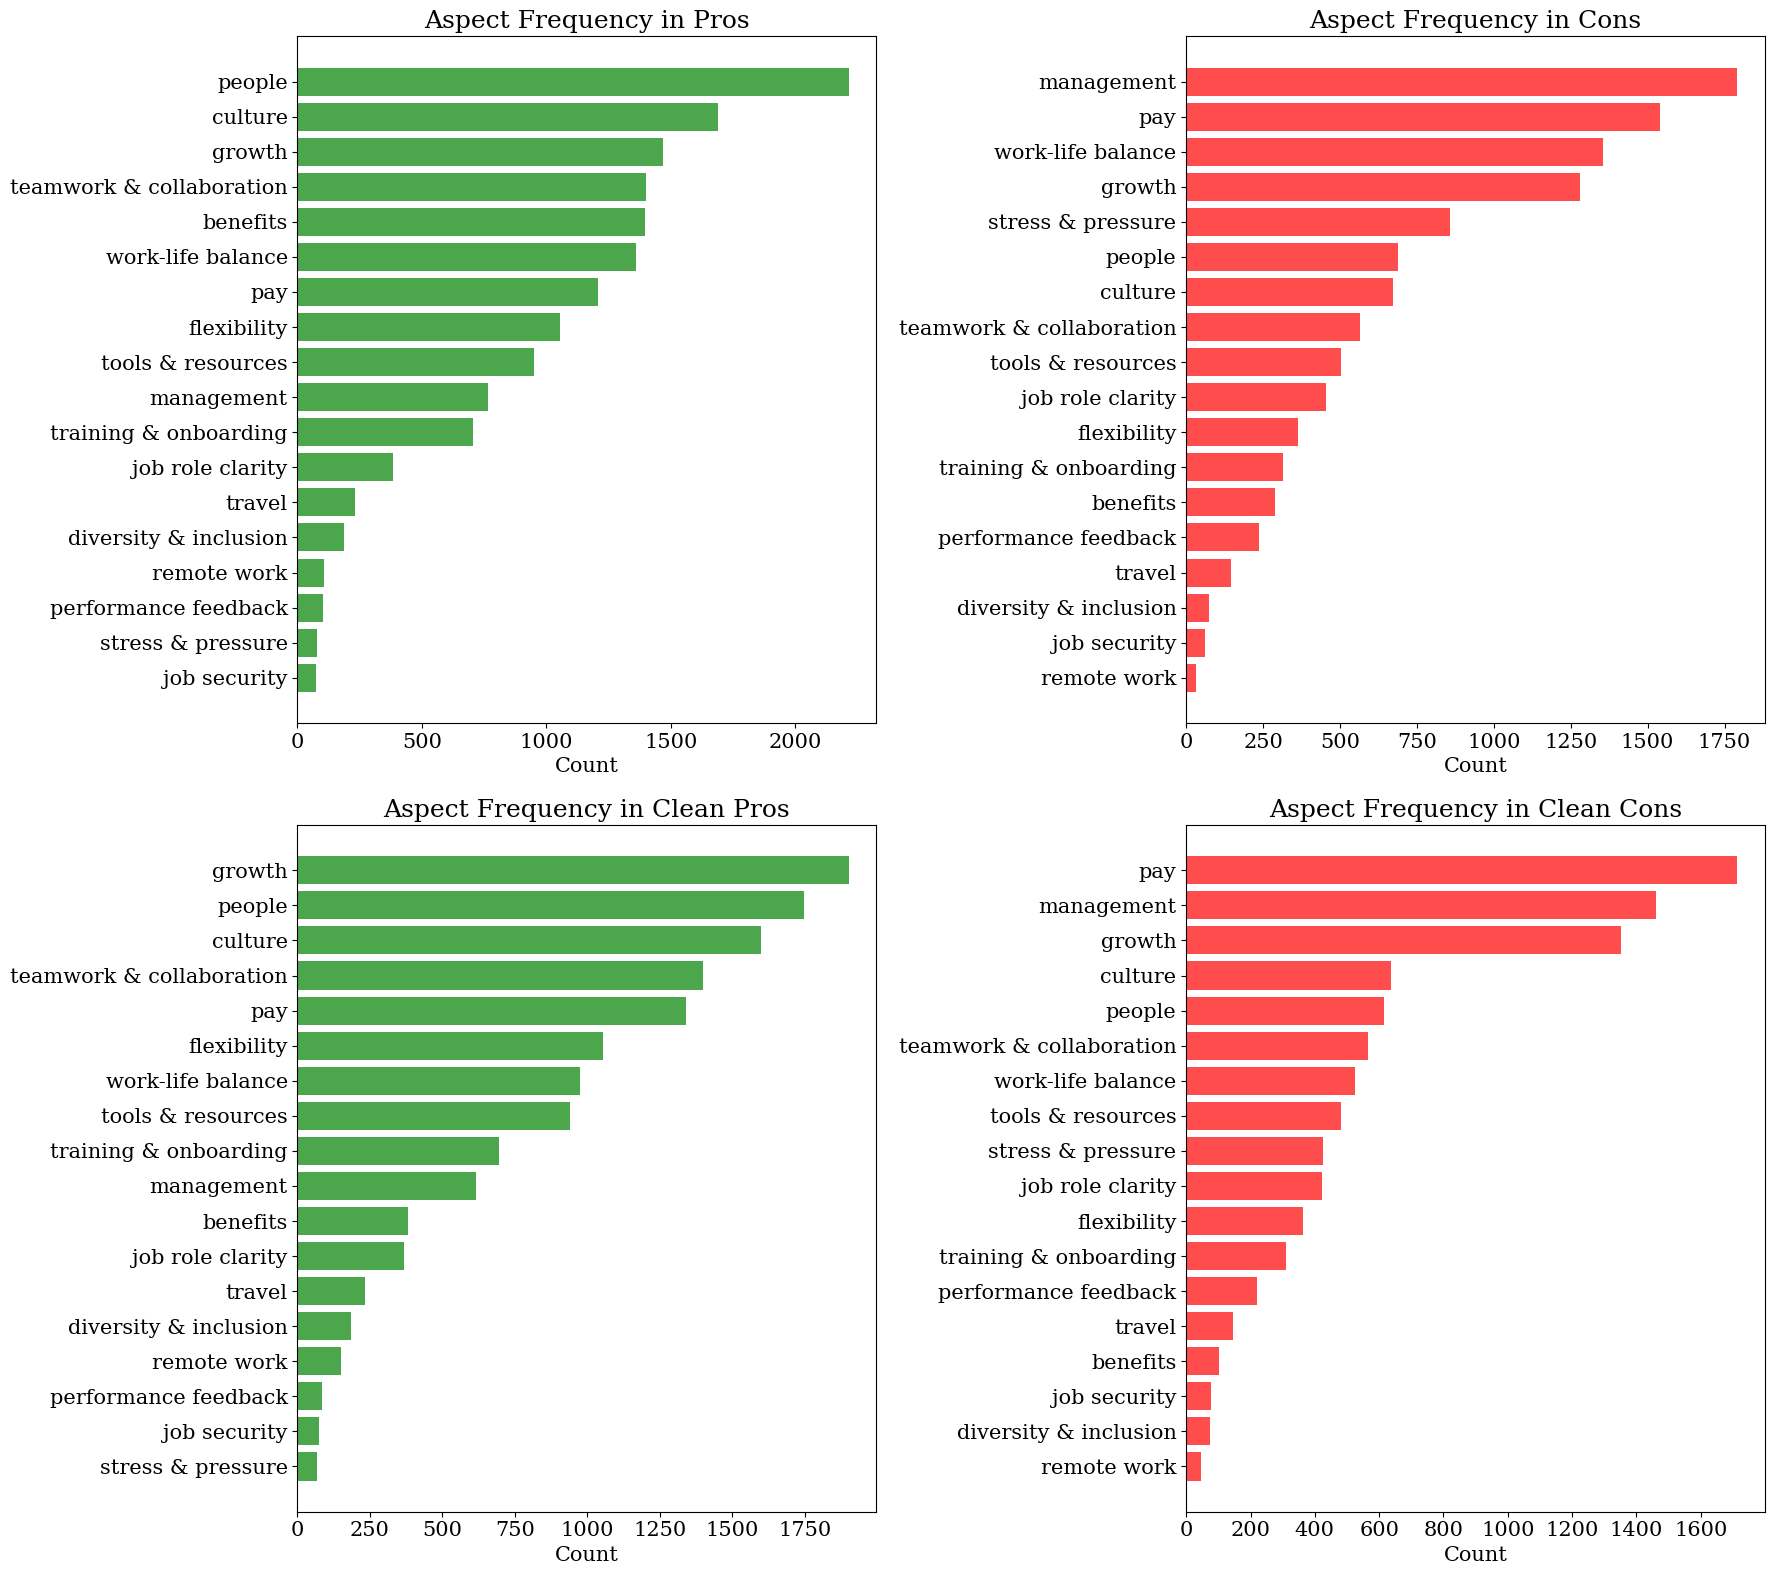

In [19]:
import matplotlib.pyplot as plt

# Prepare data (already done earlier)
# pro_data, con_data, pro_data_clean, con_data_clean assumed to be available

# Create 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(18, 16))  # Wider and taller figure for readability

# Plot 1: Pros
axs[0, 0].barh([a for a, c in pro_data], [c for a, c in pro_data], color='green', alpha=0.7)
axs[0, 0].set_title("Aspect Frequency in Pros")
axs[0, 0].set_xlabel("Count")

# Plot 2: Cons
axs[0, 1].barh([a for a, c in con_data], [c for a, c in con_data], color='red', alpha=0.7)
axs[0, 1].set_title("Aspect Frequency in Cons")
axs[0, 1].set_xlabel("Count")

# Plot 3: Clean Pros
axs[1, 0].barh([a for a, c in pro_data_clean], [c for a, c in pro_data_clean], color='green', alpha=0.7)
axs[1, 0].set_title("Aspect Frequency in Clean Pros")
axs[1, 0].set_xlabel("Count")

# Plot 4: Clean Cons
axs[1, 1].barh([a for a, c in con_data_clean], [c for a, c in con_data_clean], color='red', alpha=0.7)
axs[1, 1].set_title("Aspect Frequency in Clean Cons")
axs[1, 1].set_xlabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()


In [20]:
df_sample.to_csv('aspect_checsk.csv')

In [21]:
print("Uncleaned counts:")
print(f"{'Aspect':<25}{'Pros Count':>12}{'Cons Count':>12}")
print("-" * 50)

for aspect in all_aspects:
    pros = pro_counts.get(aspect, 0)
    cons = con_counts.get(aspect, 0)
    print(f"{aspect:<25}{pros:>12}{cons:>12}")


Uncleaned counts:
Aspect                     Pros Count  Cons Count
--------------------------------------------------
pay                              1209        1539
management                        765        1792
work-life balance                1360        1355
growth                           1469        1281
stress & pressure                  80         856
culture                          1688         672
diversity & inclusion             185          73
travel                            233         145
benefits                         1395         288
remote work                       108          32
flexibility                      1055         364
people                           2214         687
training & onboarding             706         316
job role clarity                  382         455
tools & resources                 952         503
performance feedback              101         236
job security                       73          60
teamwork & collaboration       

In [22]:
print("Cleaned counts:")
print(f"{'Aspect':<25}{'Pros Count':>12}{'Cons Count':>12}")
print("-" * 50)

for aspect in all_aspects:
    pros = pro_counts_clean.get(aspect, 0)
    cons = con_counts_clean.get(aspect, 0)
    print(f"{aspect:<25}{pros:>12}{cons:>12}")


Cleaned counts:
Aspect                     Pros Count  Cons Count
--------------------------------------------------
pay                              1341        1714
management                        615        1460
work-life balance                 975         524
growth                           1901        1352
stress & pressure                  67         425
culture                          1598         638
diversity & inclusion             185          74
travel                            233         145
benefits                          382         102
remote work                       151          46
flexibility                      1055         364
people                           1748         615
training & onboarding             695         309
job role clarity                  369         423
tools & resources                 939         481
performance feedback               85         220
job security                       73          78
teamwork & collaboration         

## Aggregate the aspects per company

In [19]:
# 1–2. Flatten aspect sentiment results from pro + con columns
from collections import defaultdict

def flatten_aspect_sentiments(row, source):
    results = []
    firm = row.get('firm') or row.get('company')  # fallback
    sentiments = row.get(source, {})
    for aspect, scores in sentiments.items():
        # Aggregate actual star rating (1–5)
        rating = scores.get("label")
        all_stars = {i: scores.get(i, 0.0) for i in range(1, 6)}

        results.append({
            "firm": firm,
            "aspect": aspect,
            "source": source.replace('_aspect_sentiments', ''),  # 'pro' or 'con'
            "star_rating": rating,
            **all_stars
        })
    return results

In [ ]:
# 3. Apply to full dataset
flattened = []
for _, row in df_sample.iterrows():
    flattened += flatten_aspect_sentiments(row, 'pro_aspect_sentiments')
    flattened += flatten_aspect_sentiments(row, 'con_aspect_sentiments')

flat_df = pd.DataFrame(flattened)

# 4. Aggregate star ratings + count mentions per company/aspect
company_aspect_matrix = flat_df.groupby(['firm', 'aspect'])['star_rating'].agg(
    avg_star_rating='mean',
    n_mentions='count'
).reset_index()
company_aspect_pivot = company_aspect_matrix.pivot(
    index='firm',
    columns='aspect',
    values='avg_star_rating'
)


# 6. Export
company_aspect_matrix.to_csv('company_aspect_matrix_with_counts.csv', index=False)
company_aspect_pivot.to_csv('company_aspect_matrix_wide.csv', index=False)


In [24]:
company_aspect_matrix

,firm,aspect,avg_star_rating,n_mentions
0,AFH Wealth Management,benefits,3.00,2
1,AFH Wealth Management,culture,5.00,1
2,AFH Wealth Management,flexibility,1.00,1
3,AFH Wealth Management,management,2.75,4
4,AFH Wealth Management,pay,3.00,2
...,...,...,...,...
3751,the LEGO Group,people,4.25,4
3752,the LEGO Group,stress & pressure,1.00,1
3753,the LEGO Group,teamwork & collaboration,4.00,1
3754,the LEGO Group,tools & resources,4.00,1


In [25]:
company_aspect_pivot

aspect,benefits,culture,diversity & inclusion,flexibility,growth,job role clarity,job security,management,pay,people,performance feedback,remote work,stress & pressure,teamwork & collaboration,tools & resources,training & onboarding,travel,work-life balance
firm,,,,,,,,,,,,,,,,,,
AFH Wealth Management,3.000000,5.000000,NaN,1.000000,NaN,NaN,NaN,2.750000,3.000000,3.333333,2.50,NaN,NaN,2.500000,1.000000,3.00,NaN,2.500000
AJ Bell,2.333333,3.750000,1.0,4.000000,4.666667,NaN,NaN,3.142857,2.500000,3.666667,NaN,NaN,NaN,3.500000,4.333333,5.00,NaN,4.000000
ASOS,3.760000,3.692308,4.0,2.571429,2.833333,2.833333,NaN,2.111111,2.615385,3.227273,2.75,NaN,1.400000,3.785714,3.428571,5.00,3.0,3.538462
AXA UK,3.875000,3.428571,4.0,4.250000,3.100000,2.000000,NaN,2.600000,2.833333,4.090909,1.50,NaN,2.000000,5.000000,2.666667,3.00,NaN,4.500000
Abcam,3.500000,4.250000,NaN,5.000000,3.833333,3.000000,NaN,NaN,3.000000,5.000000,NaN,NaN,NaN,2.000000,NaN,3.00,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YOOX NET A PORTER GROUP,3.250000,2.800000,NaN,2.000000,1.666667,NaN,NaN,1.333333,2.444444,3.500000,NaN,NaN,1.000000,2.600000,1.000000,1.00,4.0,4.000000
ibis,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,4.00,NaN,4.000000
mydentist UK,NaN,NaN,NaN,NaN,4.500000,4.000000,NaN,4.500000,1.000000,NaN,NaN,NaN,NaN,5.000000,4.500000,4.00,NaN,NaN


## Javi

### Comparing top_aspects with aspects dictionary:

In [26]:
# 1. Normalise everything to lowercase
existing_keys = {k.lower() for k in aspect_groups.keys()}

# flatten every keyword in the dictionary
existing_keywords = {kw.lower() for kws in aspect_groups.values() for kw in kws}

# 2. Compare
# a) aspects that are missing entirely
missing_new_keys = [asp for asp in top_aspects
                    if asp.lower() not in existing_keys
                    and asp.lower() not in existing_keywords]

# b) aspects that already exist as *keywords* but not as a top‑level key
present_as_keyword = [asp for asp in top_aspects
                      if asp.lower() not in existing_keys    # not a key
                      and asp.lower() in existing_keywords]  # but inside values

print("🔍 Candidates to ADD as new keys:")
for asp in missing_new_keys:
    print("  •", asp)

print("\n✅ Already present as a keyword (maybe promote to key?):")
for asp in present_as_keyword:
    print("  •", asp)

🔍 Candidates to ADD as new keys:
  • experience
  • communication
  • learning
  • employer
  • work
  • opportunities
  • projects
  • annual leave
  • staff
  • company
  • place
  • facilities
  • office
  • food
  • processes
  • health
  • safety
  • location
  • employee benefits
  • teams
  • structure
  • breaks
  • job
  • workplace
  • talent
  • building
  • offices
  • discount
  • discounts
  • time
  • selling
  • bonuses
  • uniform
  • clients
  • progression
  • manager
  • sick pay
  • business
  • recruitment
  • workload
  • skills
  • sales
  • money
  • organisation
  • service
  • everyone
  • courses
  • holidays
  • ladder
  • working
  • employees
  • pace
  • management team
  • coffee
  • conditions
  • systems
  • bank
  • learn
  • paid
  • incentives
  • security
  • salaries
  • employers
  • hr
  • innovation
  • they
  • shifts
  • cons
  • morale
  • bureaucracy
  • targets
  • tape
  • politics
  • change
  • process
  • call
  • senior management
  

In [27]:
modified_aspect_groups = {
    "pay": ["pay", "salary", "compensation", "wage", "income", "bonus"],
    "management": ["management", "managers", "leadership", "boss", "supervisor"],
    "work-life balance": ["work-life balance", "balance", "working hours", "hours", "flexibility", "overtime", "holiday"],
    "growth": ["growth", "grow", "career", "promotion", "advancement", "development", "opportunity", "progress"],
    "stress & pressure": ["stress", "pressure", "burnout", "demanding", "high pressure", "overload", "long hours", "stressful"],
    "culture": ["culture", "environment", "atmosphere", "company culture", "values"],
    "diversity & inclusion": ["diversity", "inclusion", "equality", "equity", "inclusive", "minority", "belonging"],
    "travel": ["travel", "commute", "commuting", "relocation", "mobility"],
    "benefits": ["benefits", "perks", "healthcare", "insurance", "pension", "rewards", "gym", "lunch", "dental"],
    "remote work": ["remote", "work from home", "wfh", "home office", "hybrid", "telework"],
    "flexibility": ["flexible", "flexibility", "adjustable schedule", "shift", "adaptable"],
    "people": ["people", "colleagues", "collegues", "coworker", "coworkers", "community", "teammates"],
    "training & onboarding": ["training", "onboarding", "orientation", "new hire", "introduction", "induction"],
    "job role clarity": ["role", "responsibility", "job description", "tasks", "duties", "expectation", "scope"],
    "tools & resources": ["tools", "resources", "equipment", "software", "support", "access", "tech stack", "technology"],
    "performance feedback": ["feedback", "review", "appraisal", "evaluation", "performance", "supervision", "goals"],
    "job security": ["job security", "layoff", "firing", "termination", "redundancy", "stable job"],
    "teamwork & collaboration": ["team", "teamwork", "collaboration", "supportive", "helpful", "team spirit", "group"]
}

for asp in missing_new_keys:
    modified_aspect_groups[asp] = [asp]

print(modified_aspect_groups)

{'pay': ['pay', 'salary', 'compensation', 'wage', 'income', 'bonus'], 'management': ['management', 'managers', 'leadership', 'boss', 'supervisor'], 'work-life balance': ['work-life balance', 'balance', 'working hours', 'hours', 'flexibility', 'overtime', 'holiday'], 'growth': ['growth', 'grow', 'career', 'promotion', 'advancement', 'development', 'opportunity', 'progress'], 'stress & pressure': ['stress', 'pressure', 'burnout', 'demanding', 'high pressure', 'overload', 'long hours', 'stressful'], 'culture': ['culture', 'environment', 'atmosphere', 'company culture', 'values'], 'diversity & inclusion': ['diversity', 'inclusion', 'equality', 'equity', 'inclusive', 'minority', 'belonging'], 'travel': ['travel', 'commute', 'commuting', 'relocation', 'mobility'], 'benefits': ['benefits', 'perks', 'healthcare', 'insurance', 'pension', 'rewards', 'gym', 'lunch', 'dental'], 'remote work': ['remote', 'work from home', 'wfh', 'home office', 'hybrid', 'telework'], 'flexibility': ['flexible', 'fle

In [28]:
from pprint import pprint

pprint(modified_aspect_groups, compact=False, width=120)


{'annual leave': ['annual leave'],
 'bank': ['bank'],
 'benefits': ['benefits', 'perks', 'healthcare', 'insurance', 'pension', 'rewards', 'gym', 'lunch', 'dental'],
 'bonuses': ['bonuses'],
 'breaks': ['breaks'],
 'building': ['building'],
 'bureaucracy': ['bureaucracy'],
 'business': ['business'],
 'call': ['call'],
 'change': ['change'],
 'clients': ['clients'],
 'coffee': ['coffee'],
 'communication': ['communication'],
 'company': ['company'],
 'conditions': ['conditions'],
 'cons': ['cons'],
 'courses': ['courses'],
 'culture': ['culture', 'environment', 'atmosphere', 'company culture', 'values'],
 'discount': ['discount'],
 'discounts': ['discounts'],
 'diversity & inclusion': ['diversity', 'inclusion', 'equality', 'equity', 'inclusive', 'minority', 'belonging'],
 'employee benefits': ['employee benefits'],
 'employees': ['employees'],
 'employer': ['employer'],
 'employers': ['employers'],
 'everyone': ['everyone'],
 'experience': ['experience'],
 'facilities': ['facilities'],
 

### Manually grouping aspects into key - keyword pairs:

In [11]:
modified_aspect_groups = {
'learning': ['learn','learning','knowledge','courses','academics','academic','academy','student','students','teaching','university'],
 'social dynamics': ['attitude','bullying','interaction','gossip','dress code'],
 'benefit': ['benefit','benefits','employee benefits', 'perks','health', 'healthcare', 'insurance', 'pension','pension scheme', 'rewards', 'gym', 'lunch', 'dental','benefits package','package','nhs','stock','discount', 'discounts'],
 'infrastructure': ['building','buildings','facilities','space','room','infrastructure','campus','canteen','parking'],
 'bureaucracy': ['bureaucracy','bureaucratic', 'red tape', 'tape','politics'],
 'contract': ['contract','contracts','terms','conditions'],
 'culture': ['culture','family', 'environment', 'atmosphere', 'company culture', 'values','enviroment','work environment','morale','communication','communications','vision','sustainability'],
 'diversity & inclusion': ['diversity', 'inclusion', 'equality', 'equity', 'inclusive', 'minority', 'belonging'],
 'food & drink': ['food','coffee','drink','drinks','meal','meals'],
 'flexibility': ['flexible', 'flexibility', 'adjustable schedule', 'shift', 'adaptable','break', 'breaks'],
 'growth': ['growth', 'grow', 'career', 'promotion','promotions', 'advancement', 'development', 'opportunity', 'progress','opportunities','progression','career progression'],
 'hr & recruitment': ['hr','recruitment','talent','staff','staff members','staffing','policies'],
 'job role clarity': ['role', 'responsibility', 'job description', 'tasks', 'duties', 'expectation', 'scope'],
 'job security': ['job security','security','safety', 'layoff', 'firing', 'termination', 'redundancy', 'stable job','employment','staff turnover','turnover'],
 'management': ['directors','management', 'managers','leader','leaders', 'leadership', 'boss', 'supervisor','supervisors','ceo','bosses','directors','management structure','management team','middle management','senior management','structure'],
 'office & location': ['office','office environment', 'office location', 'office space','offices','location','locations','area','workplace'],
 'pay': ['pay','paid','money', 'salary', 'compensation', 'wage','wages', 'income', 'bonus','bonuses', 'reward','salaries','sick pay','incentives','pay rates','commission'],
 'people': ['people', 'colleagues', 'collegues', 'coworker', 'coworkers', 'community', 'teammates','social','crew'],
 'performance feedback': ['feedback', 'review', 'appraisal', 'evaluation', 'performance', 'supervision', 'goals','targets','kpi'],
 'remote work': ['remote', 'work from home', 'wfh', 'home office', 'hybrid', 'telework'],
 'stress & pressure': ['stress','paced environment','pace','pressure','burnout','demanding','high pressure','overload','long hours','stressful'],
 'teamwork & collaboration': ['team', 'teams','teamwork', 'collaboration', 'supportive', 'helpful', 'team spirit', 'group'],
 'technology & innovation': ['technology','tech','innovation','technologies','research'],
 'tools & resources': ['tools', 'resources', 'equipment', 'software', 'support', 'access', 'tech stack', 'technology'],
 'training & onboarding': ['training', 'onboarding', 'orientation', 'new hire', 'introduction', 'induction'],
 'travel': ['travel','travelling', 'commute', 'commuting', 'relocation', 'mobility'],
 'work-life balance': ['work-life balance','workload','weekends', 'balance', 'working hours', 'hours', 'flexibility', 'overtime', 'holiday','life balance','lifestyle','annual leave','christmas']}

## Trying out aspect detection with new dictionary

Note: I modified the sample size above to 1% in order to run the analysis faster

In [12]:
# 1. Use new dictionary
aspect_groups = modified_aspect_groups

# 2. Remove old aspect-sentiment columns
df_sample = df_sample.drop(
    columns=[
        'pro_aspect_sentiments',
        'con_aspect_sentiments',
        'Clean_pro_aspect_sentiments',
        'Clean_con_aspect_sentiments'
    ],
    errors='ignore'
)

In [15]:
# 3.  Re‑detect aspects with the new dictionary only for uncleaned pros and cons
from tqdm.notebook import tqdm
tqdm.pandas()

df_sample['pro_aspect_sentiments'] = df_sample['pros_clean'].progress_apply(
    lambda txt: analyze_all_aspect_groups(txt, aspect_groups, tone='pos')
)

df_sample['con_aspect_sentiments'] = df_sample['cons_clean'].progress_apply(
    lambda txt: analyze_all_aspect_groups(txt, aspect_groups, tone='neg')
)


  0%|          | 0/8845 [00:00<?, ?it/s]

  0%|          | 0/8845 [00:00<?, ?it/s]

In [17]:
# 4.  Counts per aspect
from collections import Counter

pro_counts_new = Counter()
con_counts_new = Counter()

for row in df_sample['pro_aspect_sentiments'].dropna():
    pro_counts_new.update(row.keys())
for row in df_sample['con_aspect_sentiments'].dropna():
    con_counts_new.update(row.keys())

print("🔄  New counts with modified dictionary\n")
print(f"{'Aspect':<30}{'Pros':>8}{'Cons':>8}")
print("-"*50)
for asp in sorted(aspect_groups):
    print(f"{asp:<30}{pro_counts_new.get(asp,0):>8}{con_counts_new.get(asp,0):>8}")


🔄  New counts with modified dictionary

Aspect                            Pros    Cons
--------------------------------------------------
benefit                           1646     396
bureaucracy                          4     257
contract                            61     156
culture                           1802     921
diversity & inclusion              185      74
flexibility                       1103     460
food & drink                       173      62
growth                            1901    1352
hr & recruitment                  1061    1181
infrastructure                     213     238
job role clarity                   369     423
job security                       137     250
learning                           613     145
management                         800    1714
office & location                  680     474
pay                               1602    1910
people                            1836     673
performance feedback                89     255
remote work     

In [20]:
# 5.  Flatten → aggregate → pivot tables
from collections import defaultdict

flat_rows = []
for idx, row in df_sample.iterrows():
    for source in ('pro_aspect_sentiments', 'con_aspect_sentiments'):
        flat_rows.extend(flatten_aspect_sentiments(row, source))

flat_df = pd.DataFrame(flat_rows)

company_aspect_matrix = flat_df.groupby(['firm', 'aspect'])['star_rating'].agg(
    avg_star_rating='mean',
    n_mentions='count'
).reset_index()

company_aspect_pivot = company_aspect_matrix.pivot(
    index='firm',
    columns='aspect',
    values='avg_star_rating'
)

# Export
company_aspect_matrix.to_csv('v2_company_aspect_matrix_with_counts.csv', index=False)
company_aspect_pivot.to_csv('v2_company_aspect_matrix_wide.csv', index=False)


### Comparing results 

In [31]:
# OLD (baseline)
baseline_long = pd.read_csv("company_aspect_matrix_with_counts.csv")
baseline_wide = pd.read_csv("company_aspect_matrix_wide_filtered.csv")

# NEW (after modified_aspect_groups)
new_long = pd.read_csv("v2_company_aspect_matrix_with_counts.csv")
new_wide = pd.read_csv("v2_company_aspect_matrix_wide.csv")

In [32]:
# sum n_mentions over all firms
old_cov = baseline_long.groupby("aspect")["n_mentions"].sum()
new_cov = new_long.groupby("aspect")["n_mentions"].sum()

# union of all aspect names, treat missing as 0
all_aspects = old_cov.index.union(new_cov.index)

coverage_delta = (new_cov.reindex(all_aspects, fill_value=0) -
                  old_cov.reindex(all_aspects, fill_value=0))\
                 .sort_values(ascending=False)

print("Change in #mentions (new − old)  — Top 10 gains/losses")
display(coverage_delta.head(10))
display(coverage_delta.tail(10))


Change in #mentions (new − old)  — Top 10 gains/losses


aspect
hr & recruitment           2242
benefit                    2042
office & location          1154
pay                         764
learning                    758
growth                      503
infrastructure              451
technology & innovation     447
culture                     363
bureaucracy                 261
Name: n_mentions, dtype: int64

aspect
teamwork & collaboration       0
travel                         0
training & onboarding        -18
tools & resources            -35
management                   -43
job role clarity             -45
stress & pressure           -209
people                      -392
work-life balance           -988
benefits                   -1683
Name: n_mentions, dtype: int64

This metric is not as informative because there is a mismatch between old aspects and new aspects -- new categories were created, or for instance "benefit" and "benefits" are counted as different categories.

In [33]:
# Coverage change per aspect (intersection only)
old_cov = baseline_long.groupby("aspect")["n_mentions"].sum()
new_cov = new_long.groupby("aspect")["n_mentions"].sum()

# aspects present in *both* runs
common_aspects = old_cov.index.intersection(new_cov.index)

coverage_delta = (new_cov.loc[common_aspects] -
                  old_cov.loc[common_aspects])\
                 .sort_values(ascending=False)

print("Change in #mentions (new − old)  — common aspects only")
print(coverage_delta)


Change in #mentions (new − old)  — common aspects only
aspect
pay                         764
growth                      503
culture                     363
job security                254
flexibility                 144
remote work                  57
performance feedback          7
diversity & inclusion         1
travel                        0
teamwork & collaboration      0
training & onboarding       -18
tools & resources           -35
management                  -43
job role clarity            -45
stress & pressure          -209
people                     -392
work-life balance          -988
Name: n_mentions, dtype: int64


Positive numbers =  new dictionary captured more reviews for that aspect.

Negative numbers = fewer reviews matched (possible over‑merging or stricter keywords).

<span style="color: red;">I'm worried about the last three aspects as they have very negative numbers. I don't understand how this could happen as in the new dictionary I've added more keywords for work-life balance for example; need to inspect further.</span>

# Clustering Companies on Aspects

Positive vibe axes: ['growth', 'culture', 'people']
Negative vibe axes: ['pay', 'management', 'hr & recruitment']


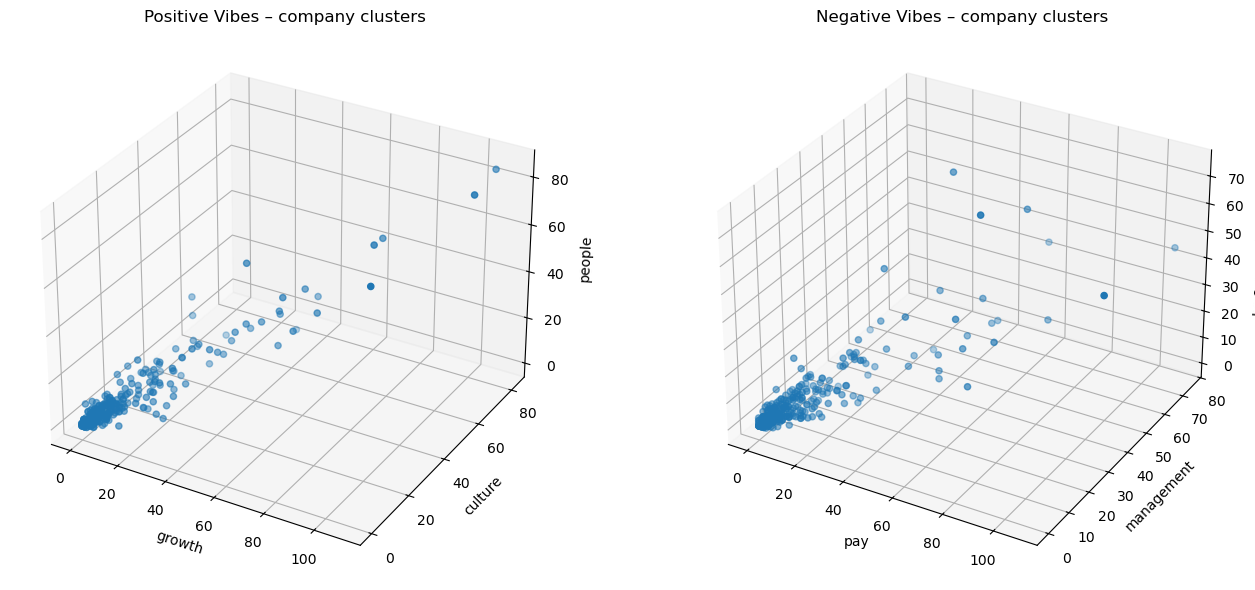

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401  (needed for 3‑D)

# 1) Load the long table
df_long = pd.read_csv("v2_company_aspect_matrix_with_counts.csv")

# 2) Pick the three most common *positive* and *negative* aspects
agg = (
    df_long
    .groupby("aspect", as_index=True)
    .agg(total_mentions=("n_mentions", "sum"),
         avg_rating=("avg_star_rating", "mean"))
)

pos_vibes = (
    agg[agg["avg_rating"] >= 3]               # strongly positive
    .sort_values("total_mentions", ascending=False)
    .head(3)
    .index.tolist()
)

neg_vibes = (
    agg[agg["avg_rating"] <= 2.9]               # strongly negative
    .sort_values("total_mentions", ascending=False)
    .head(3)
    .index.tolist()
)

print("Positive vibe axes:", pos_vibes)
print("Negative vibe axes:", neg_vibes)

# 3) Build a 3‑D “feature vector” per company
firm_counts = (
    df_long
    .pivot_table(index="firm", columns="aspect", values="n_mentions", fill_value=0)
)

pos_df = firm_counts.reindex(columns=pos_vibes, fill_value=0)
neg_df = firm_counts.reindex(columns=neg_vibes, fill_value=0)

# (Edge‑case: if fewer than 3 vibes met the threshold, add dummy zero columns)
while pos_df.shape[1] < 3:
    pos_df[f"extra{pos_df.shape[1]}"] = 0
while neg_df.shape[1] < 3:
    neg_df[f"extra{neg_df.shape[1]}"] = 0

# 4) Plot
fig = plt.figure(figsize=(14, 6))

# Positive vibes
ax_pos = fig.add_subplot(1, 2, 1, projection="3d")
ax_pos.scatter(pos_df.iloc[:, 0], pos_df.iloc[:, 1], pos_df.iloc[:, 2])
ax_pos.set_xlabel(pos_df.columns[0])
ax_pos.set_ylabel(pos_df.columns[1])
ax_pos.set_zlabel(pos_df.columns[2])
ax_pos.set_title("Positive Vibes – company clusters")

# Negative vibes
ax_neg = fig.add_subplot(1, 2, 2, projection="3d")
ax_neg.scatter(neg_df.iloc[:, 0], neg_df.iloc[:, 1], neg_df.iloc[:, 2])
ax_neg.set_xlabel(neg_df.columns[0])
ax_neg.set_ylabel(neg_df.columns[1])
ax_neg.set_zlabel(neg_df.columns[2])
ax_neg.set_title("Negative Vibes – company clusters")

plt.tight_layout()
plt.show()

## Attempt at K-Means clustering:

/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_86775/4039998046.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  customcmap = cm.get_cmap("Set1", 3)
/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_86775/4039998046.py:66: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.05, right=0.80, wspace=0.25)


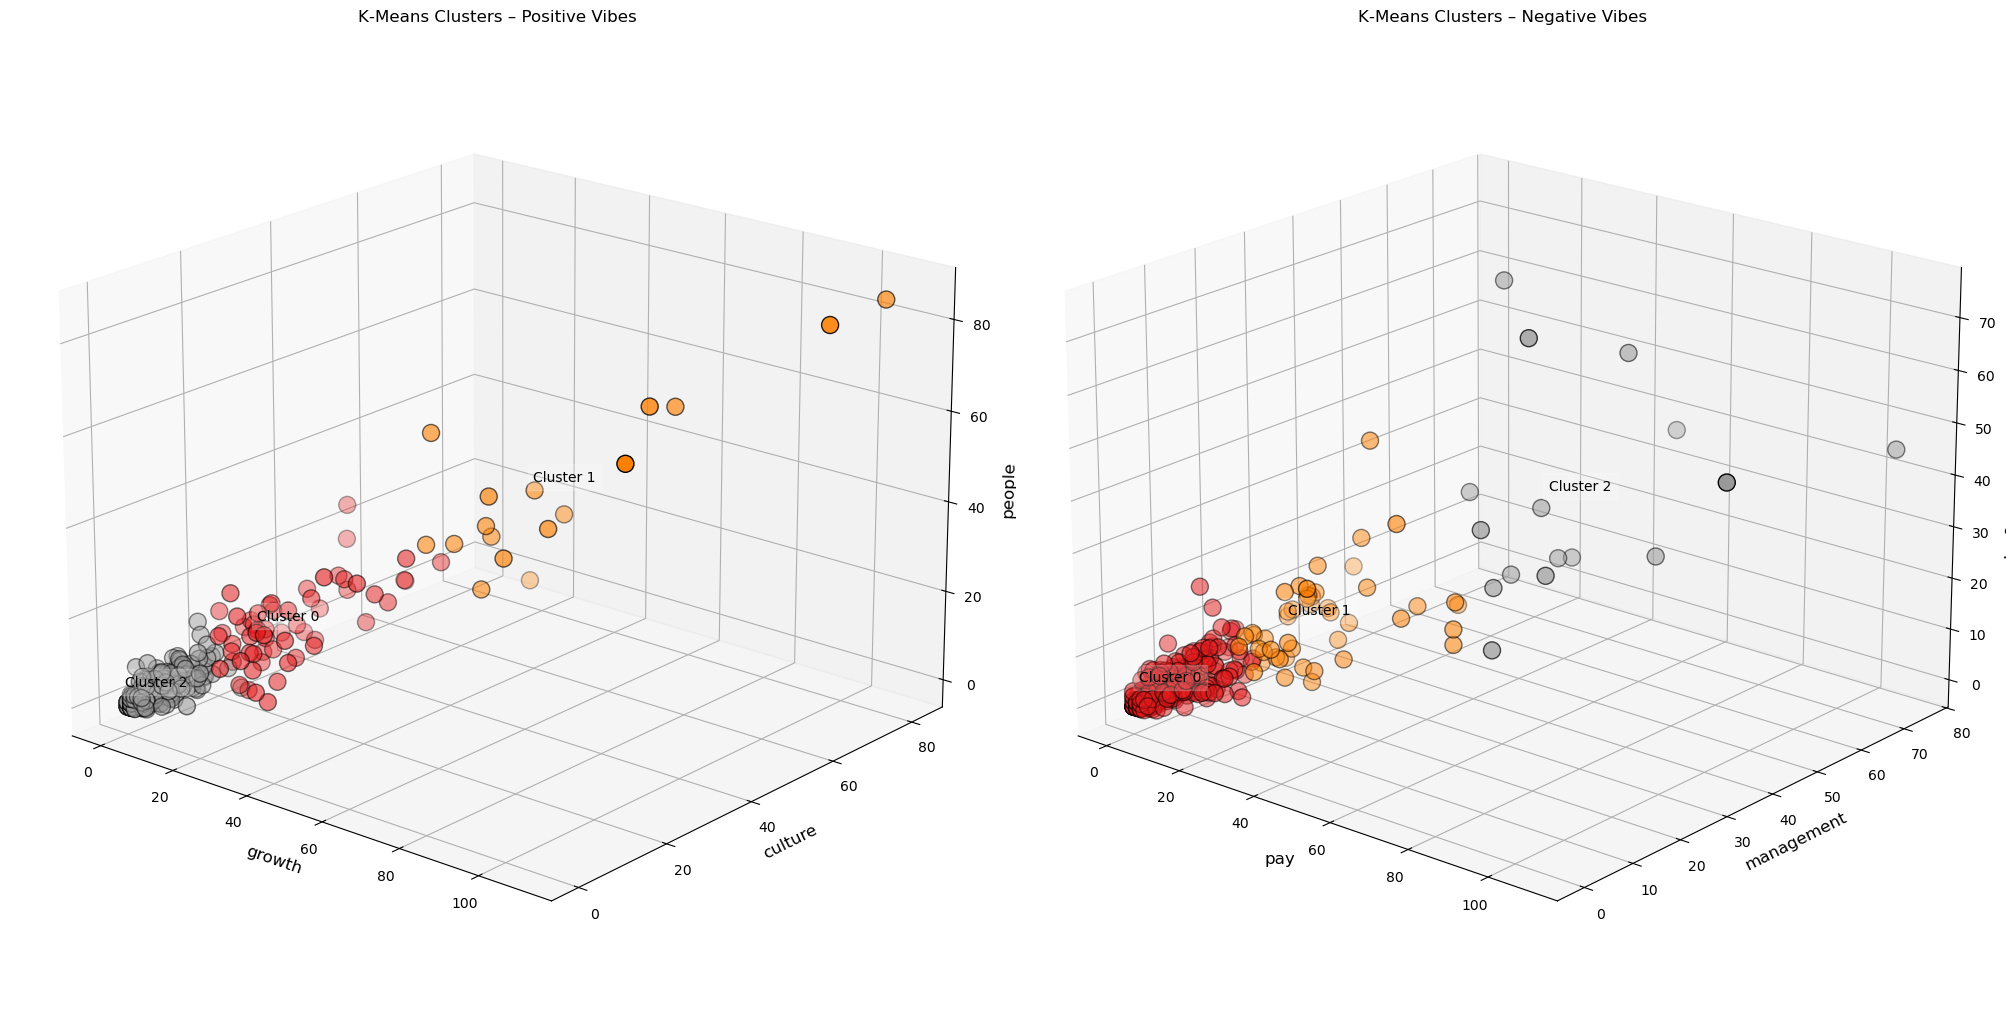

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D     # noqa: F401
from sklearn.cluster import KMeans
from matplotlib import cm

# 1. Data
X_pos = pos_df.values             
X_neg = neg_df.values

names_pos = pos_df.columns.tolist()
names_neg = neg_df.columns.tolist()

# 2.  Fit K‑means (k=3)
kmeans_pos = KMeans(n_clusters=3, n_init="auto", random_state=42).fit(X_pos)
kmeans_neg = KMeans(n_clusters=3, n_init="auto", random_state=42).fit(X_neg)

# 3.  Build a custom colour map 
customcmap = cm.get_cmap("Set1", 3) 

# 4.  Plot 
fig = plt.figure(figsize=(20, 10), constrained_layout=True)
gs  = fig.add_gridspec(2, 1, right=0.80) 

ax1.set_zlabel(names_pos[2], fontsize=12, labelpad=20)      
ax2.set_zlabel(names_neg[2], fontsize=12, labelpad=30)


# ---- Left: positive vibes ---------------------------------------------------
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.scatter(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2],
            c=kmeans_pos.labels_.astype(float),
            edgecolor="k", s=150, cmap=customcmap)

# label cluster centroids
for idx, center in enumerate(kmeans_pos.cluster_centers_):
    ax1.text3D(center[0], center[1], center[2] + 1.0,
               f"Cluster {idx}", horizontalalignment="center",
               bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"))

ax1.view_init(20, -50)
ax1.set_xlabel(names_pos[0], fontsize=12)
ax1.set_ylabel(names_pos[1], fontsize=12)
ax1.set_zlabel(names_pos[2], fontsize=12)
ax1.set_title("K‑Means Clusters – Positive Vibes", fontsize=12)

# ---- Right: negative vibes --------------------------------------------------
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.scatter(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2],
            c=kmeans_neg.labels_.astype(float),
            edgecolor="k", s=150, cmap=customcmap)

for idx, center in enumerate(kmeans_neg.cluster_centers_):
    ax2.text3D(center[0], center[1], center[2] + 1.0,
               f"Cluster {idx}", horizontalalignment="center",
               bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"))

ax2.view_init(20, -50)
ax2.set_xlabel(names_neg[0], fontsize=12)
ax2.set_ylabel(names_neg[1], fontsize=12)
ax2.set_zlabel(names_neg[2], fontsize=12)
ax2.set_title("K‑Means Clusters – Negative Vibes", fontsize=12)

# plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.80, wspace=0.25)
plt.show()

/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_86775/140380987.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  customcmap = cm.get_cmap("Set1", 3)


z‑label text: people
z‑label text: hr & recruitment


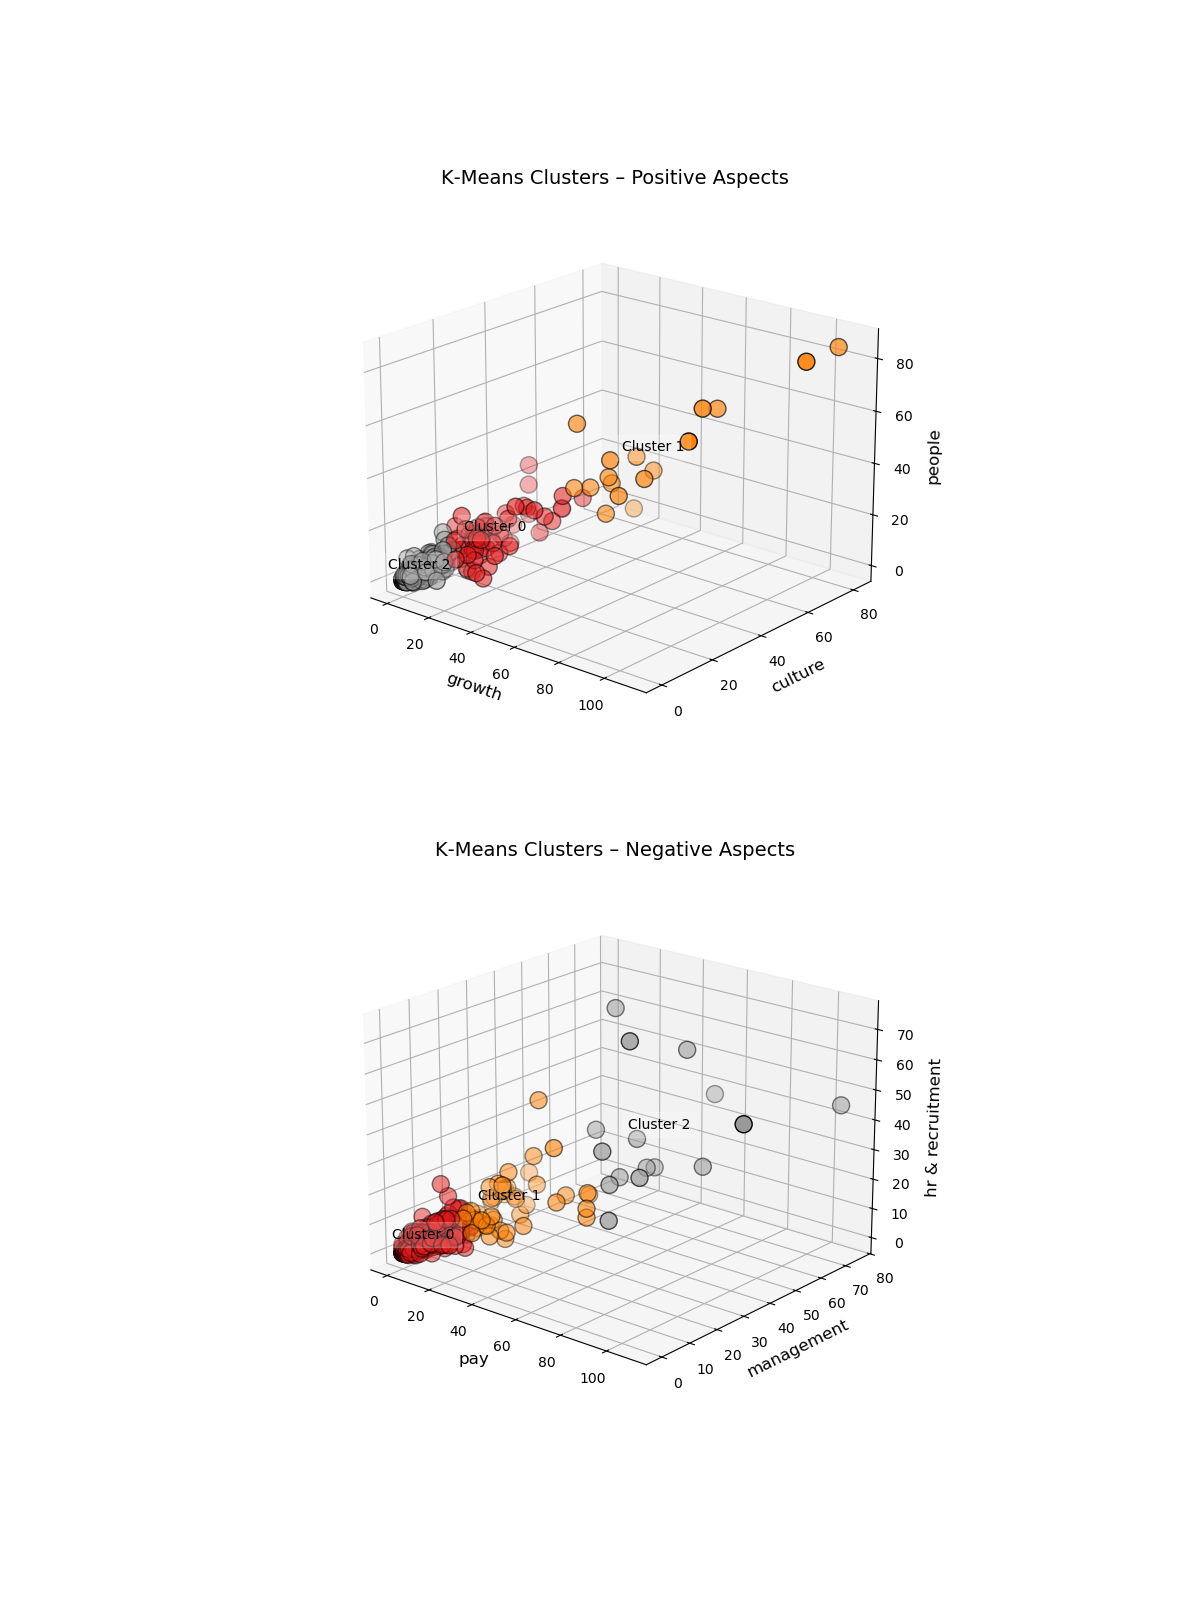

In [78]:
# Vertical layout
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

customcmap = cm.get_cmap("Set1", 3)

fig = plt.figure(figsize=(12, 16))

# ── Top panel: positive vibes ───────────────────────────────
ax1 = fig.add_subplot(2, 1, 1, projection="3d")
ax1.scatter(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2],
            c=kmeans_pos.labels_.astype(float),
            edgecolor="k", s=150, cmap=customcmap)

for idx, center in enumerate(kmeans_pos.cluster_centers_):
    ax1.text3D(center[0], center[1], center[2] + 1.0,
               f"Cluster {idx}", ha="center",
               bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"))

ax1.view_init(20, -50)
ax1.set_xlabel(names_pos[0], fontsize=12)
ax1.set_ylabel(names_pos[1], fontsize=12)
ax1.set_zlabel(names_pos[2], fontsize=12)
ax1.set_title("K‑Means Clusters – Positive Aspects", fontsize=14)

# ── Bottom panel: negative vibes ────────────────────────────
ax2 = fig.add_subplot(2, 1, 2, projection="3d")
ax2.scatter(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2],
            c=kmeans_neg.labels_.astype(float),
            edgecolor="k", s=150, cmap=customcmap)

for idx, center in enumerate(kmeans_neg.cluster_centers_):
    ax2.text3D(center[0], center[1], center[2] + 1.0,
               f"Cluster {idx}", ha="center",
               bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"))

ax2.view_init(20, -50)
ax2.set_xlabel(names_neg[0], fontsize=12)
ax2.set_ylabel(names_neg[1], fontsize=12)
ax2.set_zlabel(names_neg[2], fontsize=12)
ax2.set_title("K‑Means Clusters – Negative Aspects", fontsize=14)

print("z‑label text:", ax1.zaxis.get_label().get_text())
print("z‑label text:", ax2.zaxis.get_label().get_text())

plt.show()


# More interpretable clusters in 2D

In [ ]:
# load the long table (v2 version, already includes your new keywords)
long = pd.read_csv("v2_company_aspect_matrix_with_counts.csv")

#  weight sentiment by mention count
long["sentiment_weighted"] = long["avg_star_rating"] * long["n_mentions"]
weighted_wide = (
    long.pivot_table(index="firm",
                     columns="aspect",
                     values="sentiment_weighted")
    .fillna(0)
)

X = weighted_wide              
X = X.fillna(0)                

# centre & scale so each aspect contributes equally
X_scaled = pd.DataFrame(
    StandardScaler().fit_transform(X),
    index=X.index,
    columns=X.columns
)

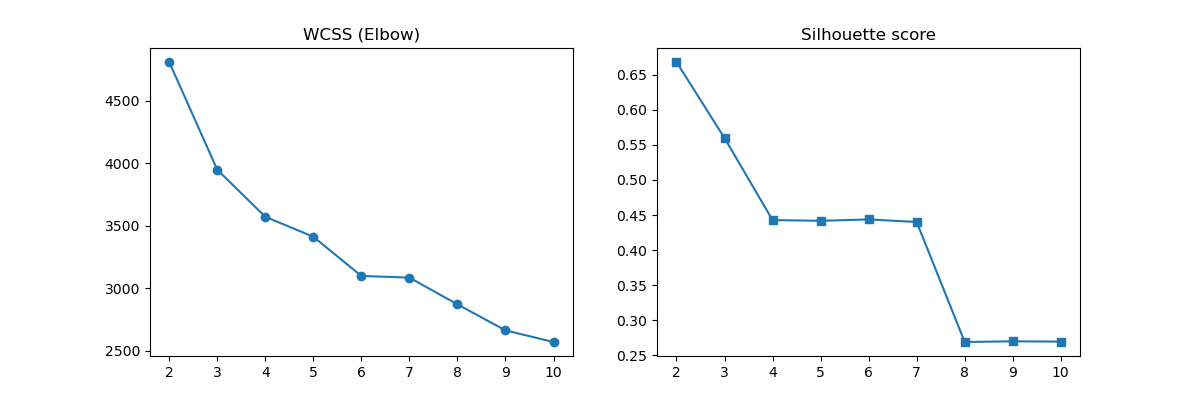

In [85]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

wcss, sil = [], []
ks = range(2, 11)

for k in ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(X_scaled)
    wcss.append(km.inertia_)
    sil.append(silhouette_score(X_scaled, km.labels_))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(ks, wcss, marker="o");      ax[0].set_title("WCSS (Elbow)")
ax[1].plot(ks, sil, marker="s");       ax[1].set_title("Silhouette score")
plt.show()


## N° of clusters = 3, using ALL Aspects

In [101]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Z = linkage(X_scaled, method="ward")
labels = fcluster(Z, t=3, criterion="maxclust")   # 3 clusters 

# Attach cluster labels to the DataFrame for browsing
firm_clusters = X_scaled.copy()
firm_clusters["cluster"] = labels

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


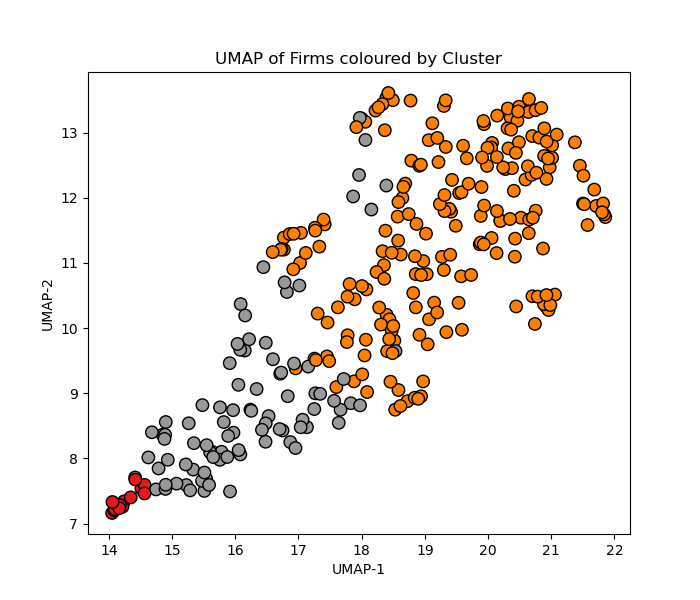

In [102]:
embedding = umap.UMAP(n_components=2, random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(7, 6))
plt.scatter(embedding[:,0], embedding[:,1],
            c=labels, cmap="Set1", edgecolor="k", s=80)
plt.title("UMAP of Firms coloured by Cluster")
plt.xlabel("UMAP‑1"); plt.ylabel("UMAP‑2")
plt.show()

In [103]:
for cl in sorted(set(labels)):
    sub = X.loc[firm_clusters["cluster"] == cl]
    mean = sub.mean().sort_values(ascending=False)
    print(f"\n🟢 Cluster {cl}  (n={len(sub)})")
    print(mean.head(10))   # 5 aspects with highest mean score / weight


🟢 Cluster 1  (n=13)
aspect
growth                      226.846154
people                      174.692308
pay                         155.692308
culture                     153.384615
benefit                     109.461538
teamwork & collaboration    109.461538
work-life balance           108.615385
flexibility                  94.461538
tools & resources            92.076923
management                   82.307692
dtype: float64

🟢 Cluster 2  (n=210)
aspect
growth                      10.228571
pay                          9.814286
people                       9.523810
culture                      9.490476
teamwork & collaboration     8.723810
hr & recruitment             7.957143
benefit                      7.409524
management                   6.652381
tools & resources            5.752381
work-life balance            4.947619
dtype: float64

🟢 Cluster 3  (n=90)
aspect
growth                      57.566667
culture                     54.955556
pay                         54.622222
b

In [107]:
#Understanding how the aspects are related to the clusters

umap_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"], index=X.index)
both    = pd.concat([umap_df, X], axis=1)

corrs = both.corr().loc[["UMAP1", "UMAP2"], X.columns]

# show top 5 positive/negative correlations for each component
for comp in ["UMAP1", "UMAP2"]:
    print(f"{comp} – aspects with strongest influence")
    print(corrs.loc[comp].sort_values(key=np.abs, ascending=False).head(6))


UMAP1 – aspects with strongest influence
aspect
management                 -0.776060
culture                    -0.765930
pay                        -0.733613
work-life balance          -0.731122
benefit                    -0.718156
teamwork & collaboration   -0.717167
Name: UMAP1, dtype: float64
UMAP2 – aspects with strongest influence
aspect
culture             -0.745617
management          -0.715137
job role clarity    -0.690815
office & location   -0.689971
tools & resources   -0.678452
growth              -0.675404
Name: UMAP2, dtype: float64


## N° of clusters = 4

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


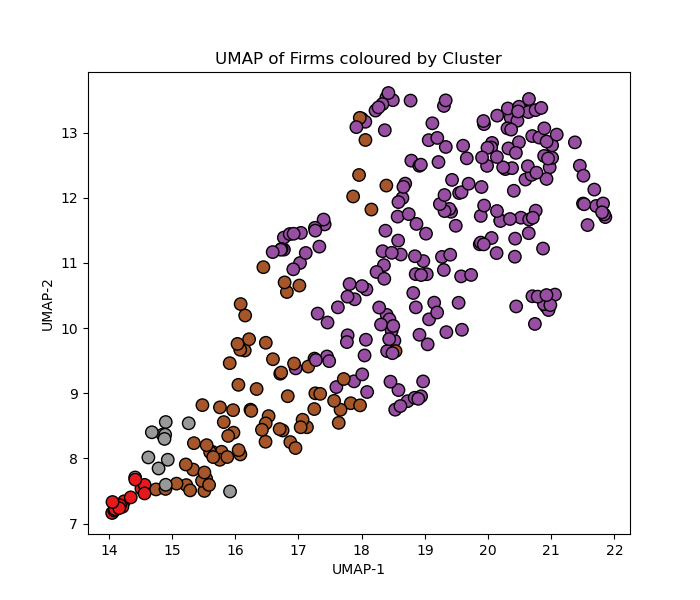

In [104]:
Z = linkage(X_scaled, method="ward")
labels = fcluster(Z, t=4, criterion="maxclust")   # 4 clusters 

# Attach cluster labels to the DataFrame for browsing
firm_clusters = X_scaled.copy()
firm_clusters["cluster"] = labels

embedding = umap.UMAP(n_components=2, random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(7, 6))
plt.scatter(embedding[:,0], embedding[:,1],
            c=labels, cmap="Set1", edgecolor="k", s=80)
plt.title("UMAP of Firms coloured by Cluster")
plt.xlabel("UMAP‑1"); plt.ylabel("UMAP‑2")
plt.show()

In [105]:
for cl in sorted(set(labels)):
    sub = X.loc[firm_clusters["cluster"] == cl]
    mean = sub.mean().sort_values(ascending=False)
    print(f"\n🟢 Cluster {cl}  (n={len(sub)})")
    print(mean.head(10))   # 5 aspects with highest mean score / weight


🟢 Cluster 1  (n=13)
aspect
growth                      226.846154
people                      174.692308
pay                         155.692308
culture                     153.384615
benefit                     109.461538
teamwork & collaboration    109.461538
work-life balance           108.615385
flexibility                  94.461538
tools & resources            92.076923
management                   82.307692
dtype: float64

🟢 Cluster 2  (n=210)
aspect
growth                      10.228571
pay                          9.814286
people                       9.523810
culture                      9.490476
teamwork & collaboration     8.723810
hr & recruitment             7.957143
benefit                      7.409524
management                   6.652381
tools & resources            5.752381
work-life balance            4.947619
dtype: float64

🟢 Cluster 3  (n=78)
aspect
growth                      52.923077
culture                     50.051282
pay                         42.115385
p

## Now selecting fewer aspects ~3

Keeping 3 aspects:
 ['pay', 'work-life balance', 'culture']


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


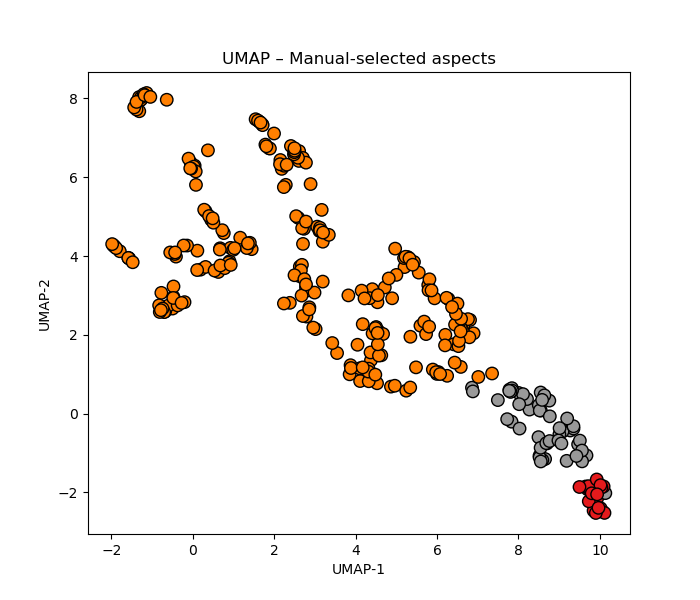

In [169]:
#  Choose a feature‑selection strategy

STRATEGY = "manual"      # "variance" | "mentions" | "manual"
N_KEEP   = 3               # how many aspects to keep

# 1) build the full matrix
full  = long.pivot_table(index="firm", columns="aspect",
                         values="sentiment_weighted").fillna(0)

# 2) pick columns based on strategy
if STRATEGY == "variance":
    variances = full.var().sort_values(ascending=False)
    cols = variances.head(N_KEEP).index

elif STRATEGY == "mentions":
    total_mentions = (
        long.groupby("aspect")["n_mentions"].sum()
        .sort_values(ascending=False)
    )
    cols = total_mentions.head(N_KEEP).index

elif STRATEGY == "manual":
    cols = [
        "pay", "work-life balance",
        "culture"]
else:
    raise ValueError("STRATEGY must be variance, mentions, or manual")

print(f"Keeping {len(cols)} aspects:\n", list(cols))

X_sel = full[cols]

# 3) scale + cluster + UMAP 
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_sel)

from sklearn.cluster import AgglomerativeClustering
clust = AgglomerativeClustering(n_clusters=3, linkage="ward").fit(X_scaled) #adjust number of clusters
labels = clust.labels_

import umap.umap_ as umap
emb = umap.UMAP(random_state=42).fit_transform(X_scaled)

import matplotlib.pyplot as plt
plt.figure(figsize=(7,6))
plt.scatter(emb[:,0], emb[:,1], c=labels, cmap="Set1", edgecolor="k", s=80)
plt.title(f"UMAP – {STRATEGY.capitalize()}‑selected aspects")
plt.xlabel("UMAP‑1"); plt.ylabel("UMAP‑2")
for i, txt in enumerate(X_sel.index):
    # uncomment next line if you want firm names
    # plt.annotate(txt, (emb[i,0], emb[i,1]), fontsize=6)
    pass
plt.show()


Displaying the full matrix below. Each value corresponds to: sentiment_weighted = (average star rating * number of mentions) for each aspect

In [182]:
pd.options.display.max_rows = 5          # show all firms (rows)
pd.options.display.max_columns = None       # show all aspects (cols)
pd.options.display.width = 0                # let HTML table decide width
pd.options.display.max_colwidth = 30        # truncate long aspect names
display(full)                               # renders as a scrollable HTML table

aspect,benefit,bureaucracy,contract,culture,diversity & inclusion,flexibility,food & drink,growth,hr & recruitment,infrastructure,job role clarity,job security,learning,management,office & location,pay,people,performance feedback,remote work,social dynamics,stress & pressure,teamwork & collaboration,technology & innovation,tools & resources,training & onboarding,travel,work-life balance
firm,,,,,,,,,,,,,,,,,,,,,,,,,,,
AFH Wealth Management,5.0,0.0,0.0,5.0,0.0,1.0,0.0,0.0,9.0,4.0,0.0,0.0,4.0,5.0,4.0,6.0,6.0,5.0,0.0,0.0,0.0,5.0,0.0,1.0,4.0,0.0,9.0
AJ Bell,7.0,0.0,0.0,16.0,1.0,4.0,4.0,14.0,11.0,6.0,0.0,5.0,0.0,18.0,10.0,14.0,22.0,0.0,0.0,0.0,4.0,7.0,0.0,13.0,5.0,0.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
next,180.0,0.0,20.0,122.0,0.0,216.0,8.0,44.0,193.0,24.0,12.0,5.0,17.0,84.0,28.0,156.0,115.0,8.0,0.0,5.0,29.0,106.0,6.0,27.0,55.0,1.0,84.0
the LEGO Group,5.0,0.0,0.0,18.0,0.0,1.0,0.0,4.0,3.0,0.0,1.0,0.0,0.0,10.0,1.0,5.0,12.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0,0.0,0.0,5.0


In [170]:
clusters = X_sel.copy()
clusters["cluster"] = labels      # 0, 1, 2, …
profile = (
    clusters.groupby("cluster")
            .mean()               # average value of each of the aspects
            .round(2)
            .sort_index()
)

print(profile)


aspect      pay  work-life balance  culture
cluster                                    
0        157.67              92.95   131.38
1         11.59               6.11    11.25
2         55.92              38.38    66.83


In [171]:
sizes = clusters["cluster"].value_counts().sort_index()
print("\nCluster sizes:\n", sizes, "\n")

for cl in sorted(clusters["cluster"].unique()):
    print(f"🟢 Cluster {cl} • {sizes.loc[cl]} firms")
    print(", ".join(clusters.query("cluster == @cl").index[:10]), "…\n")


Cluster sizes:
 cluster
0     21
1    240
2     52
Name: count, dtype: int64 

🟢 Cluster 0 • 21 firms
Accenture, BT, Barclays, British Airways, Capita, Deloitte, Dixons Carphone, EY, HSBC Holdings, Hays …

🟢 Cluster 1 • 240 firms
AFH Wealth Management, AJ Bell, AXA UK, Abcam, Accor, Active Care Group, Adecco, Age UK The National Charity, AlixPartners, Amey …

🟢 Cluster 2 • 52 firms
ASOS, American Express, Apple, B and M Retail, B and Q, BBC, BP, Bloomberg L P, Booking com, Bupa …



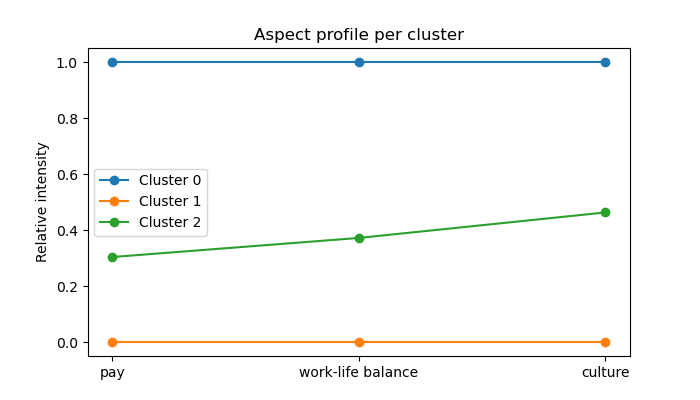

In [ ]:
# rescale 0–1 for nicer plotting
from sklearn.preprocessing import MinMaxScaler
scaled = pd.DataFrame(
    MinMaxScaler().fit_transform(profile),
    index=profile.index,
    columns=profile.columns
)

fig, ax = plt.subplots(figsize=(7,4))
for cl, row in scaled.iterrows():
    ax.plot(row.index, row.values, marker="o", label=f"Cluster {cl}")
ax.set_ylabel("Relative intensity"); ax.legend()
plt.title("Aspect profile per cluster"); plt.show()


/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_86775/3877610797.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  customcmap = cm.get_cmap("Set1", len(labels_unique))


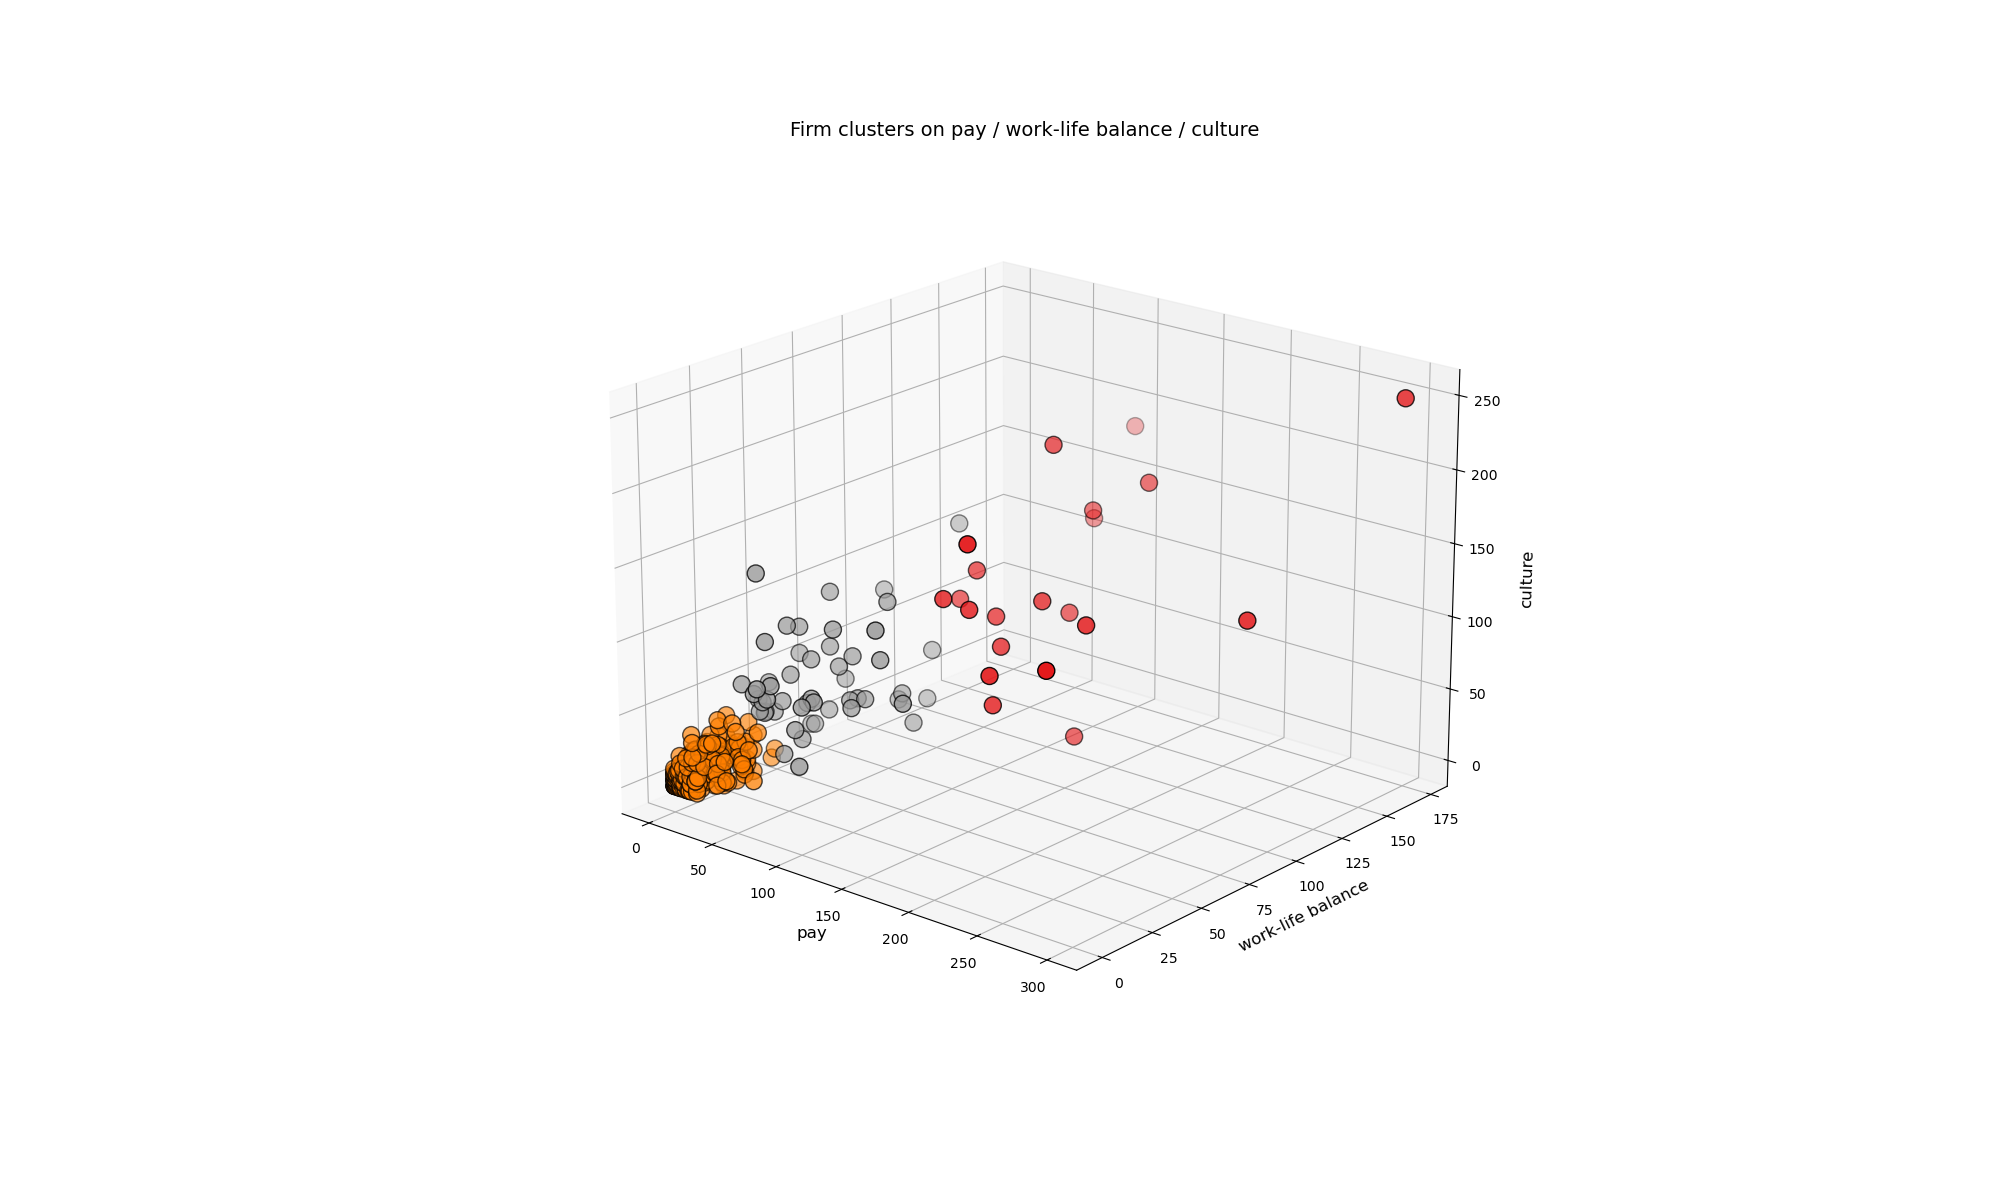

In [185]:
# 3‑D scatter of firms on (pay, work‑life, culture)

# 1) Grab the three columns in the right order
axes = ["pay", "work-life balance", "culture"]
xyz  = X_sel[axes].values                   # shape (n_firms, 3)

# 2) Make sure labels start at 0 for colormap indexing
labels_unique = np.unique(labels)
label_map     = {old: i for i, old in enumerate(labels_unique)}
color_labels  = np.vectorize(label_map.get)(labels)

customcmap = cm.get_cmap("Set1", len(labels_unique))

# 3) Plot
fig = plt.figure(figsize=(20, 12))
ax  = fig.add_subplot(111, projection="3d")

ax.scatter(
    xyz[:, 0], xyz[:, 1], xyz[:, 2],
    c=color_labels.astype(float),
    cmap=customcmap,
    s=150, edgecolor="k"
)

# # annotate cluster centroids
# from sklearn.cluster import KMeans
# km = KMeans(n_clusters=len(labels_unique), n_init="auto", random_state=42).fit(xyz)
# for idx, center in enumerate(km.cluster_centers_):
#     ax.text(center[0], center[1], center[2] + 0.2,
#             f"Cluster {idx}", ha="center",
#             bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"))

ax.set_xlabel("pay", fontsize=12)
ax.set_ylabel("work‑life balance", fontsize=12)
ax.set_zlabel("culture", fontsize=12, labelpad=10)
ax.view_init(20, -50)
ax.set_title("Firm clusters on pay / work‑life balance / culture", fontsize=14)

plt.show()


### Trying to incorporate firm labels:

/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_86775/1016737063.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  customcmap = cm.get_cmap("Set1", len(labels_unique))


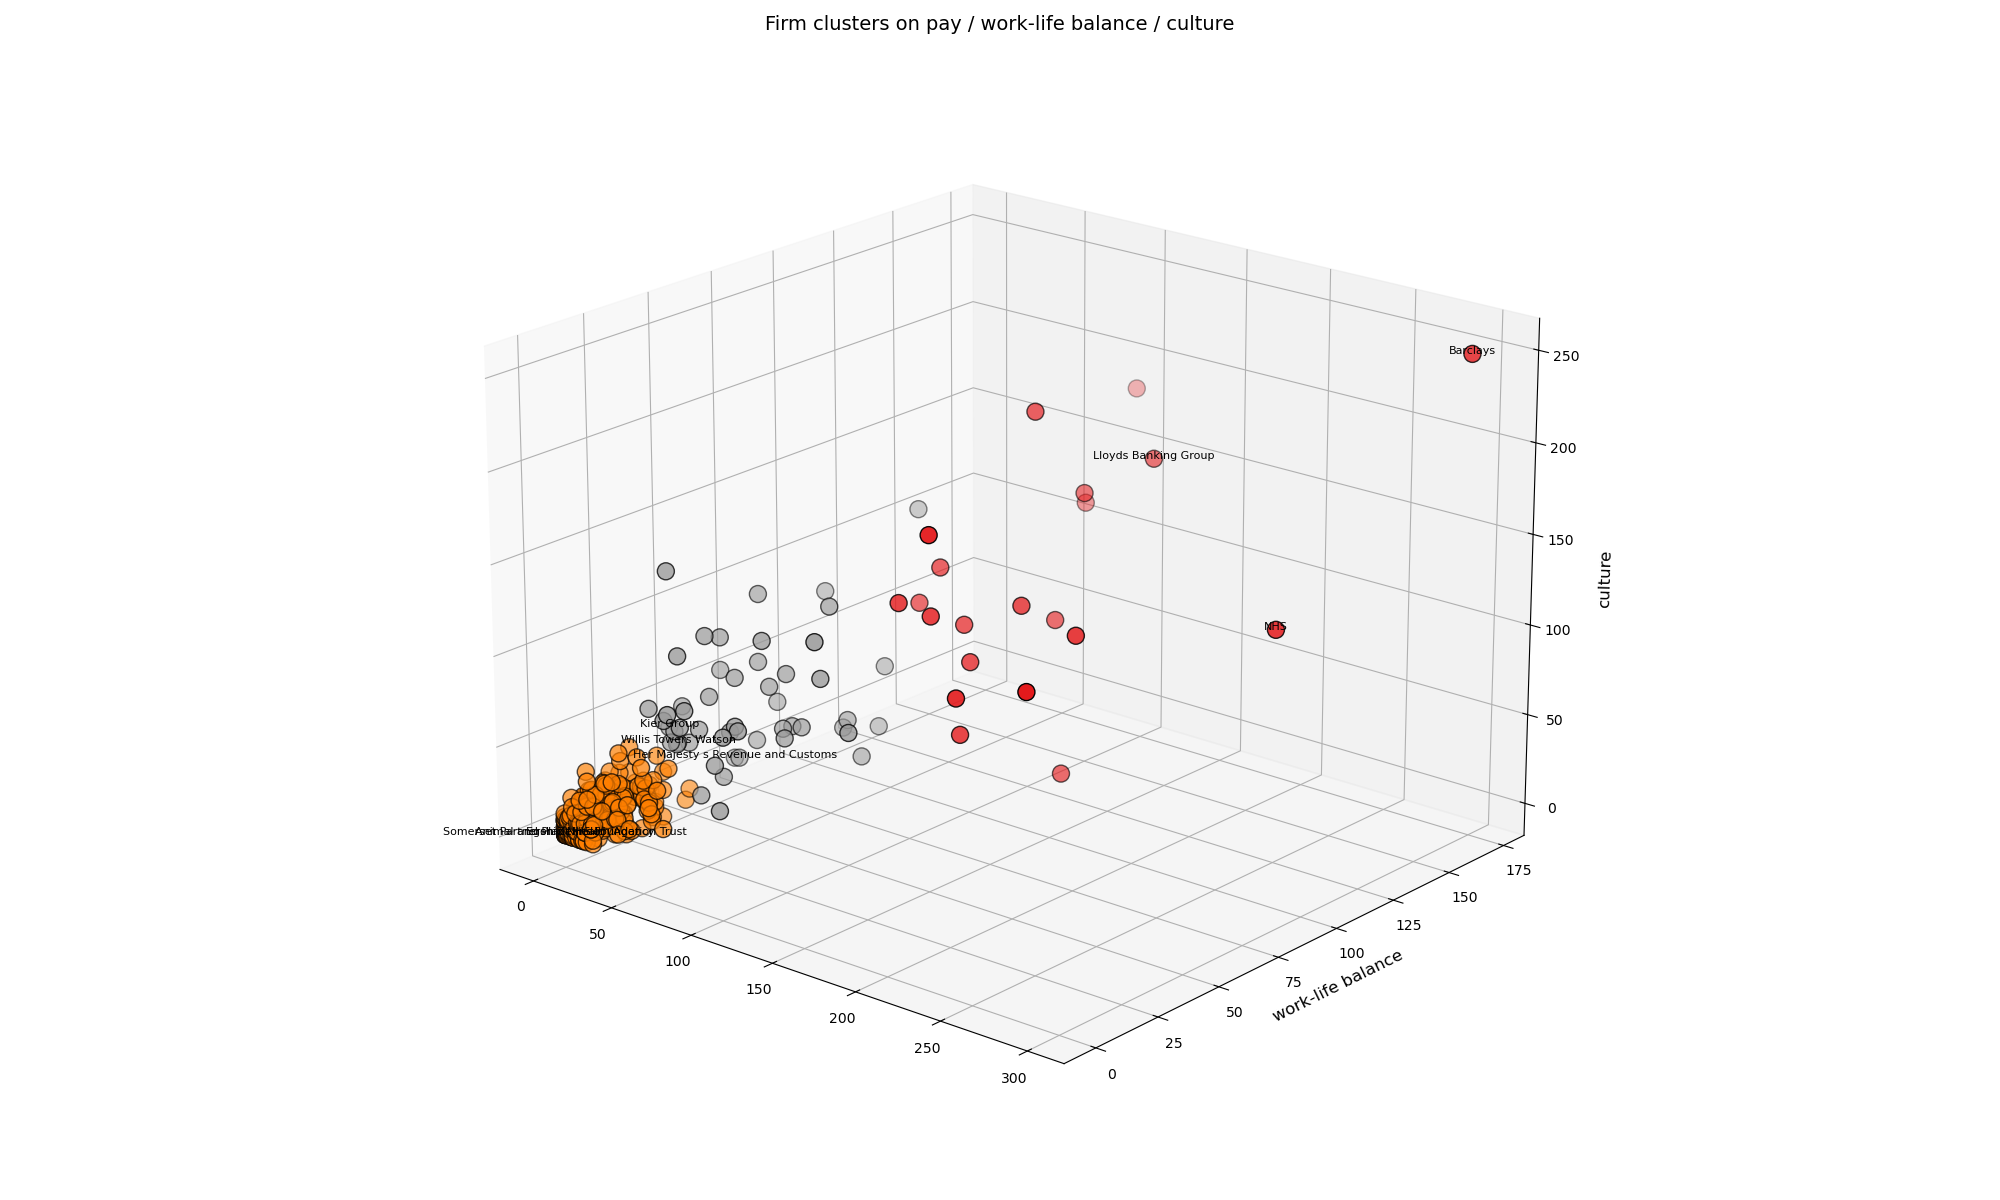

In [188]:
# 3‑D scatter + 3 firm labels per cluster
from scipy.spatial.distance import cdist

# prepare data
axes = ["pay", "work-life balance", "culture"]
xyz   = X_sel[axes].values                  # (n_firms, 3)
firms = X_sel.index.to_numpy()              # firm names

# cluster labels you already have
labels_unique = np.unique(labels)
label_map     = {old: i for i, old in enumerate(labels_unique)}
color_labels  = np.vectorize(label_map.get)(labels)

customcmap = cm.get_cmap("Set1", len(labels_unique))

# Plot
fig = plt.figure(figsize=(20, 12))
ax  = fig.add_subplot(111, projection="3d")

ax.scatter(
    xyz[:, 0], xyz[:, 1], xyz[:, 2],
    c=color_labels.astype(float),
    cmap=customcmap,
    s=150, edgecolor="k"
)

# Label cluster centroids
km = KMeans(n_clusters=len(labels_unique), n_init="auto", random_state=42).fit(xyz)
# for idx, center in enumerate(km.cluster_centers_):
#     ax.text(center[0], center[1], center[2] + 0.2,
#             f"Cluster {idx}", ha="center",
#             bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"))

# Pick 3 representatives per cluster
for cl in labels_unique:
    mask = labels == cl
    cluster_pts   = xyz[mask]
    cluster_names = firms[mask]

    # distance of each firm to its centroid
    dists = cdist(cluster_pts, km.cluster_centers_[cl].reshape(1, -1)).flatten()

    # indices of three farthest points (change 3 → 2 for two labels)
    top_idx = dists.argsort()[-3:]

    for i in top_idx:
        x, y, z = cluster_pts[i]
        name    = cluster_names[i]
        ax.text(x, y, z, name, fontsize=8, ha="center")

# Cosmetics
ax.set_ylabel("work‑life balance", fontsize=12)
ax.set_zlabel("culture", fontsize=12, labelpad=10)
ax.view_init(20, -50)
ax.set_title("Firm clusters on pay / work‑life balance / culture", fontsize=14)

plt.tight_layout()
plt.show()


## Normalizing sentiment_weighted by total number of reviews:

In [ ]:
# total reviews each firm received (across all aspects)
firm_totals = long.groupby("firm")["n_mentions"].sum()

# proportion of all mentions that are for this aspect
long["share"] = long["n_mentions"] / long["firm"].map(firm_totals)

# combine with sentiment:
long["sentiment_share"] = long["avg_star_rating"] * long["share"]

In [210]:
#  Choose a feature‑selection strategy
STRATEGY = "variance"      # "variance" | "mentions" | "manual"
N_KEEP   = 3               # how many aspects to keep

# 1) build the full matrix
# full  = long.pivot_table(index="firm", columns="aspect",
#                          values="sentiment_weighted").fillna(0)
matrix = long.pivot_table(index="firm", columns="aspect",
                          values="sentiment_share").fillna(0)

# 2) pick columns based on strategy
if STRATEGY == "variance":
    variances = matrix.var().sort_values(ascending=False)
    cols = variances.head(N_KEEP).index

elif STRATEGY == "mentions":
    total_mentions = (
        long.groupby("aspect")["n_mentions"].sum()
        .sort_values(ascending=False)
    )
    cols = total_mentions.head(N_KEEP).index

elif STRATEGY == "manual":
    cols = ["pay", "work-life balance","culture"]
else:
    raise ValueError("STRATEGY must be variance, mentions, or manual")

print(f"Keeping {len(cols)} aspects:\n", list(cols))

X_sel = matrix[cols]


Keeping 3 aspects:
 ['pay', 'culture', 'growth']


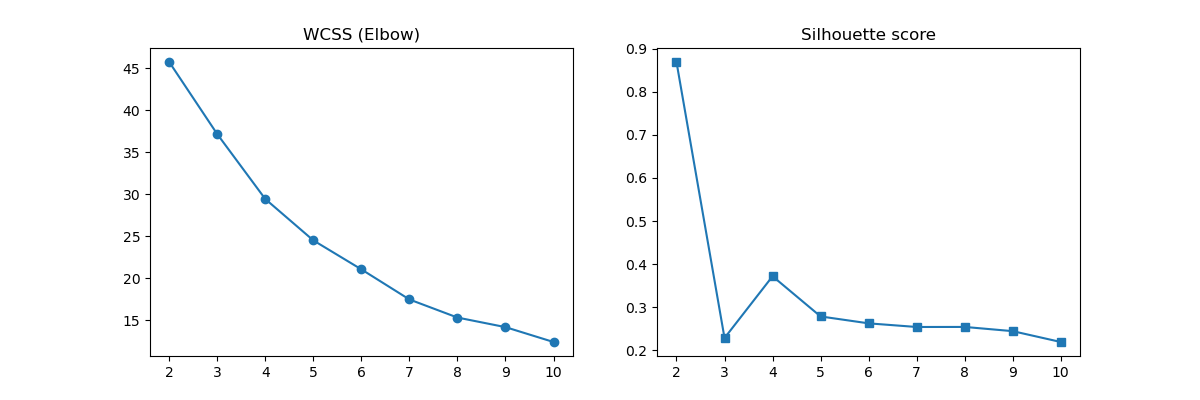

In [211]:
# 3) Checking optimal number of clusters
wcss, sil = [], []
ks = range(2, 11)

for k in ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(X_sel)
    wcss.append(km.inertia_)
    sil.append(silhouette_score(X_scaled, km.labels_))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(ks, wcss, marker="o");      ax[0].set_title("WCSS (Elbow)")
ax[1].plot(ks, sil, marker="s");       ax[1].set_title("Silhouette score")
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


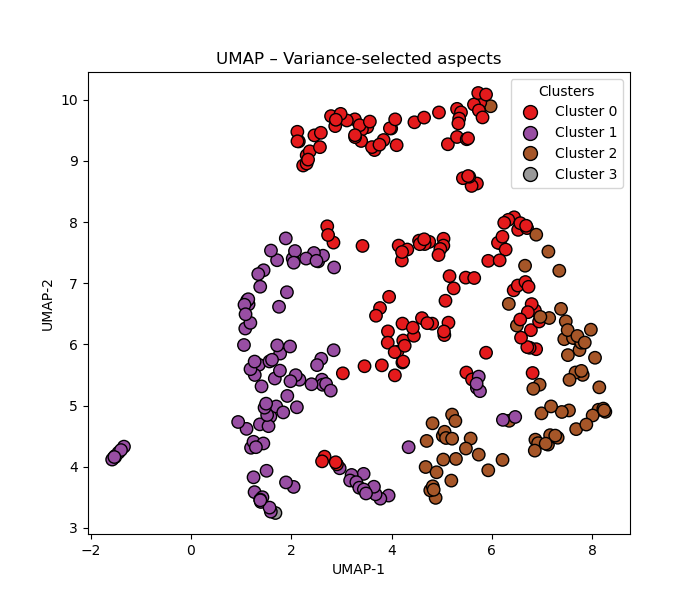

In [222]:
# 4) Plot clusters 
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_sel)

from sklearn.cluster import AgglomerativeClustering
clust = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(X_scaled) #adjust number of clusters
labels = clust.labels_

import umap.umap_ as umap
emb = umap.UMAP(random_state=42).fit_transform(X_scaled)

import matplotlib.pyplot as plt
plt.figure(figsize=(7,6))
scatter = plt.scatter(emb[:,0], emb[:,1],
                      c=labels, cmap="Set1",
                      edgecolor="k", s=80)

unique = sorted(set(labels))
handles = [ plt.Line2D([], [], marker='o', linestyle='',
                       markerfacecolor=scatter.cmap(scatter.norm(lab)),
                       markeredgecolor='k', markersize=10,
                       label=f"Cluster {lab}")
            for lab in unique ]
plt.legend(handles=handles, title="Clusters", frameon=True)

plt.title(f"UMAP – {STRATEGY.capitalize()}‑selected aspects")
plt.xlabel("UMAP‑1"); plt.ylabel("UMAP‑2")
for i, txt in enumerate(X_sel.index):
    # uncomment next line if you want firm names
    # plt.annotate(txt, (emb[i,0], emb[i,1]), fontsize=6)
    pass
plt.show()

In [191]:
pd.options.display.max_rows = 5          # show all firms (rows)
pd.options.display.max_columns = None       # show all aspects (cols)
pd.options.display.width = 0                # let HTML table decide width
pd.options.display.max_colwidth = 30        # truncate long aspect names
display(matrix)                               # renders as a scrollable HTML table

aspect,benefit,bureaucracy,contract,culture,diversity & inclusion,flexibility,food & drink,growth,hr & recruitment,infrastructure,job role clarity,job security,learning,management,office & location,pay,people,performance feedback,remote work,social dynamics,stress & pressure,teamwork & collaboration,technology & innovation,tools & resources,training & onboarding,travel,work-life balance
firm,,,,,,,,,,,,,,,,,,,,,,,,,,,
AFH Wealth Management,0.192308,0.0,0.000000,0.192308,0.000000,0.038462,0.000000,0.000000,0.346154,0.153846,0.000000,0.000000,0.153846,0.192308,0.153846,0.230769,0.230769,0.192308,0.0,0.00000,0.000000,0.192308,0.000000,0.038462,0.153846,0.000000,0.346154
AJ Bell,0.142857,0.0,0.000000,0.326531,0.020408,0.081633,0.081633,0.285714,0.224490,0.122449,0.000000,0.102041,0.000000,0.367347,0.204082,0.285714,0.448980,0.000000,0.0,0.00000,0.081633,0.142857,0.000000,0.265306,0.102041,0.000000,0.183673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
next,0.340909,0.0,0.037879,0.231061,0.000000,0.409091,0.015152,0.083333,0.365530,0.045455,0.022727,0.009470,0.032197,0.159091,0.053030,0.295455,0.217803,0.015152,0.0,0.00947,0.054924,0.200758,0.011364,0.051136,0.104167,0.001894,0.159091
the LEGO Group,0.192308,0.0,0.000000,0.692308,0.000000,0.038462,0.000000,0.153846,0.115385,0.000000,0.038462,0.000000,0.000000,0.384615,0.038462,0.192308,0.461538,0.000000,0.0,0.00000,0.038462,0.153846,0.153846,0.153846,0.000000,0.000000,0.192308


In [208]:
clusters = X_sel.copy()
clusters["cluster"] = labels      # 0, 1, 2, …
profile = (
    clusters.groupby("cluster")
            .mean()               # average value of each of the aspects
            .round(2)
            .sort_index()
)

print(profile)


aspect    pay  culture  growth
cluster                       
0        0.22     0.41    0.31
1        0.34     0.16    0.15
2        0.29     0.17    0.57
3        5.00     0.00    0.00


In [209]:
sizes = clusters["cluster"].value_counts().sort_index()
print("\nCluster sizes:\n", sizes, "\n")

for cl in sorted(clusters["cluster"].unique()):
    print(f"🟢 Cluster {cl} • {sizes.loc[cl]} firms")
    print(", ".join(clusters.query("cluster == @cl").index[:10]), "…\n")


Cluster sizes:
 cluster
0    138
1    102
2     72
3      1
Name: count, dtype: int64 

🟢 Cluster 0 • 138 firms
AJ Bell, ASOS, AXA UK, Accor, Adecco, Age UK The National Charity, American Express, Anglian Water, Apple, Aviva …

🟢 Cluster 1 • 102 firms
AFH Wealth Management, Active Care Group, Angard Staffing, Animal and Plant Health Agency, Arcadia, B and Q, BAT, BIS, BNP Paribas, BNY Mellon …

🟢 Cluster 2 • 72 firms
Abcam, Accenture, AlixPartners, Amey, Anglo American, Aon, Arnold Clark, AstraZeneca, B and M Retail, BDO …

🟢 Cluster 3 • 1 firms
Newcastle Upon Tyne Hospitals NHS …



<span style="color: red;">This Newcastle Upon Tyne Hospitals NHS company has only one review in the dataset, hence why it's clustered by itself. We could consider removing it for clustering purposes.</span>

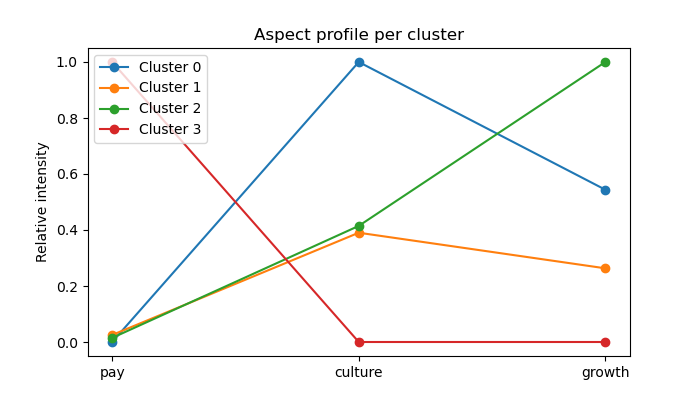

In [219]:
# rescale 0–1 for nicer plotting
from sklearn.preprocessing import MinMaxScaler
scaled = pd.DataFrame(
    MinMaxScaler().fit_transform(profile),
    index=profile.index,
    columns=profile.columns
)

fig, ax = plt.subplots(figsize=(7,4))
for cl, row in scaled.iterrows():
    ax.plot(row.index, row.values, marker="o", label=f"Cluster {cl}")
ax.set_ylabel("Relative intensity"); ax.legend()
plt.title("Aspect profile per cluster"); plt.show()


/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_86775/490339785.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  customcmap = cm.get_cmap("Set1", len(labels_unique))


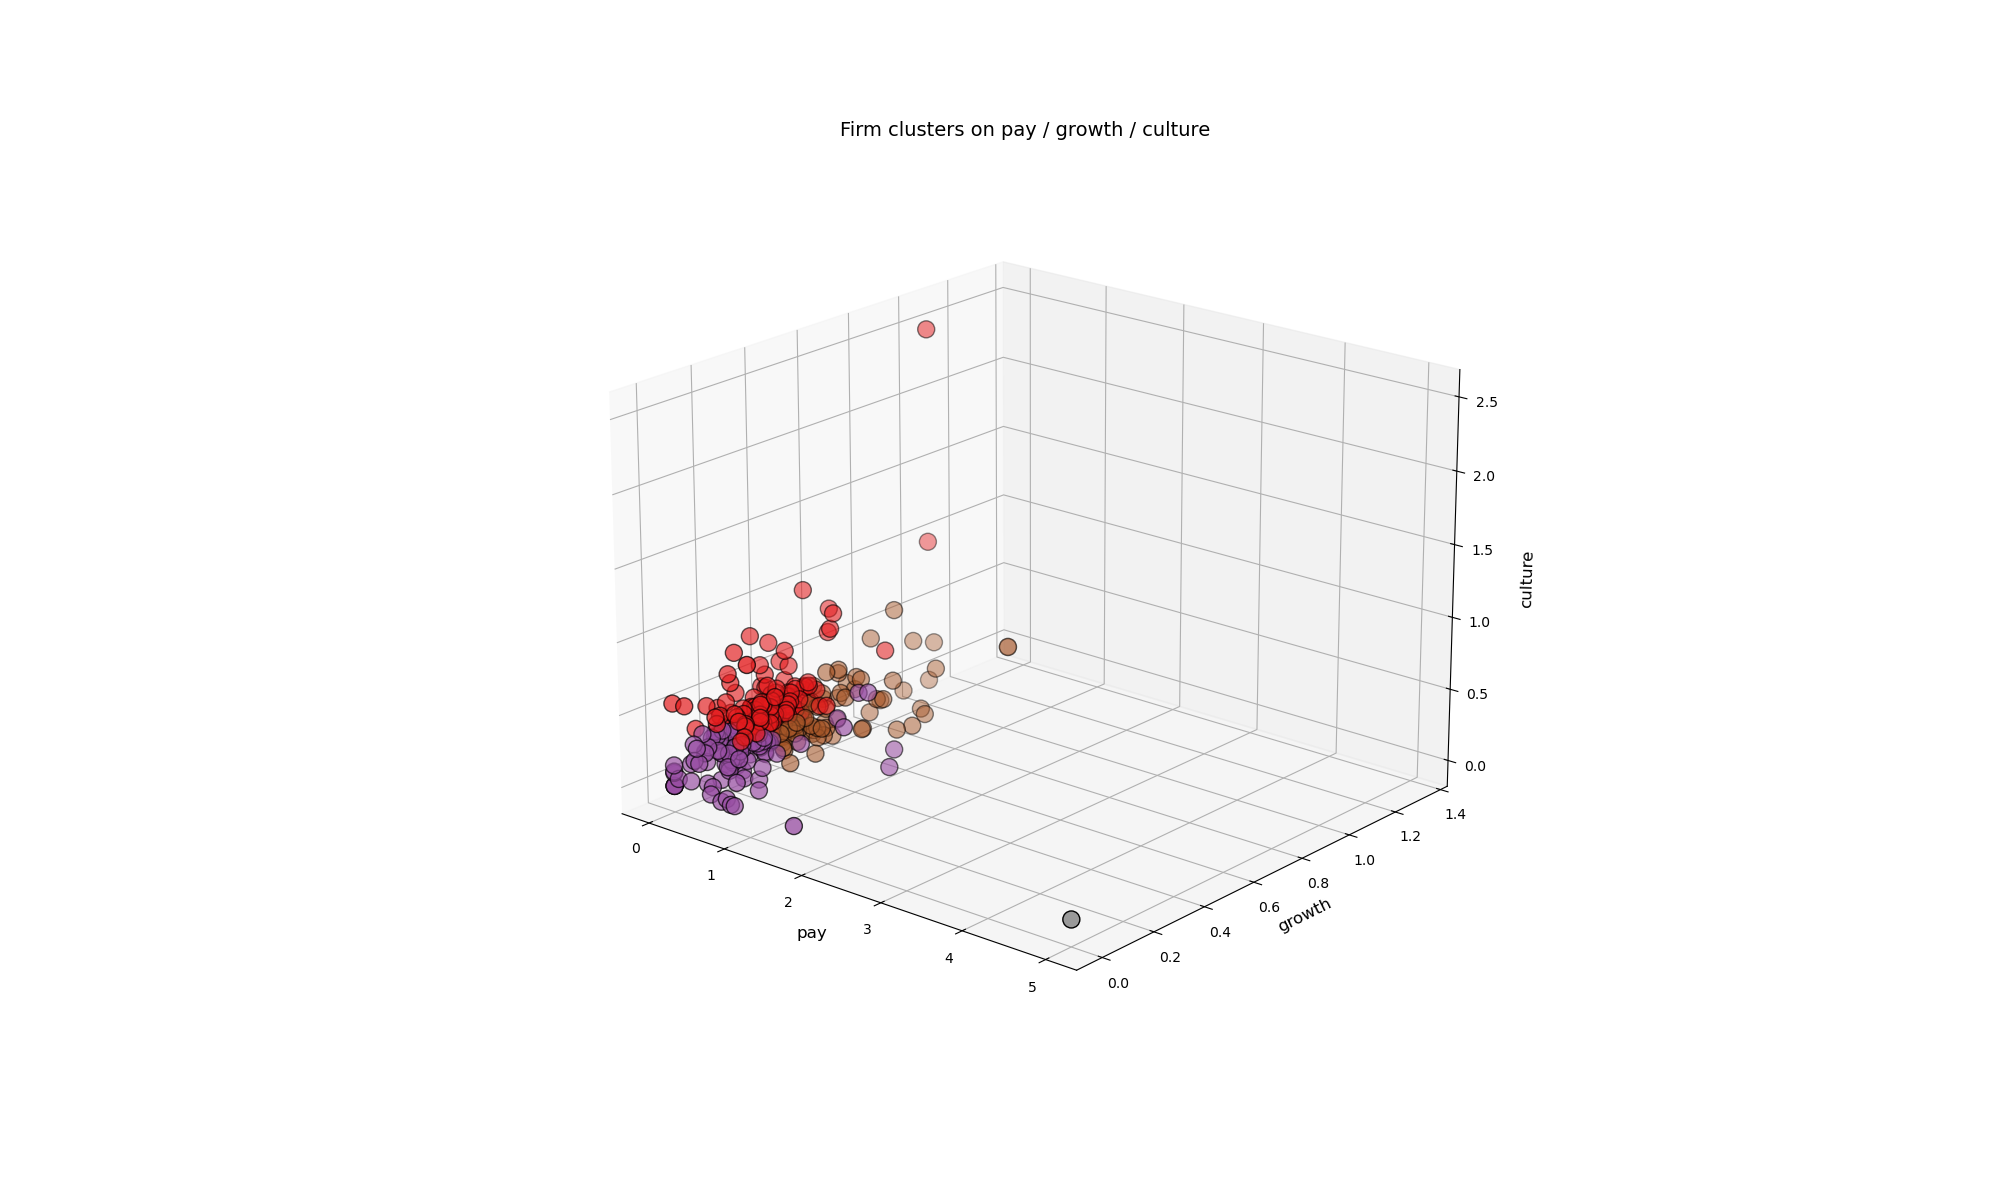

In [218]:
# 3‑D scatter of firms on (pay, work‑life, culture)

# 1) Grab the three columns in the right order
axes = ["pay", "growth", "culture"]
xyz  = X_sel[axes].values                  

# 2) Make sure labels start at 0 for colormap indexing
labels_unique = np.unique(labels)
label_map     = {old: i for i, old in enumerate(labels_unique)}
color_labels  = np.vectorize(label_map.get)(labels)

customcmap = cm.get_cmap("Set1", len(labels_unique))

# 3) Plot
fig = plt.figure(figsize=(20, 12))
ax  = fig.add_subplot(111, projection="3d")

ax.scatter(
    xyz[:, 0], xyz[:, 1], xyz[:, 2],
    c=color_labels.astype(float),
    cmap=customcmap,
    s=150, edgecolor="k"
)

ax.set_xlabel("pay", fontsize=12)
ax.set_ylabel("growth", fontsize=12)
ax.set_zlabel("culture", fontsize=12, labelpad=10)
ax.view_init(20, -50)
ax.set_title("Firm clusters on pay / growth / culture", fontsize=14)

plt.show()


/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_86775/1959189408.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  customcmap = cm.get_cmap("Set1", len(filtered_labels_unique))


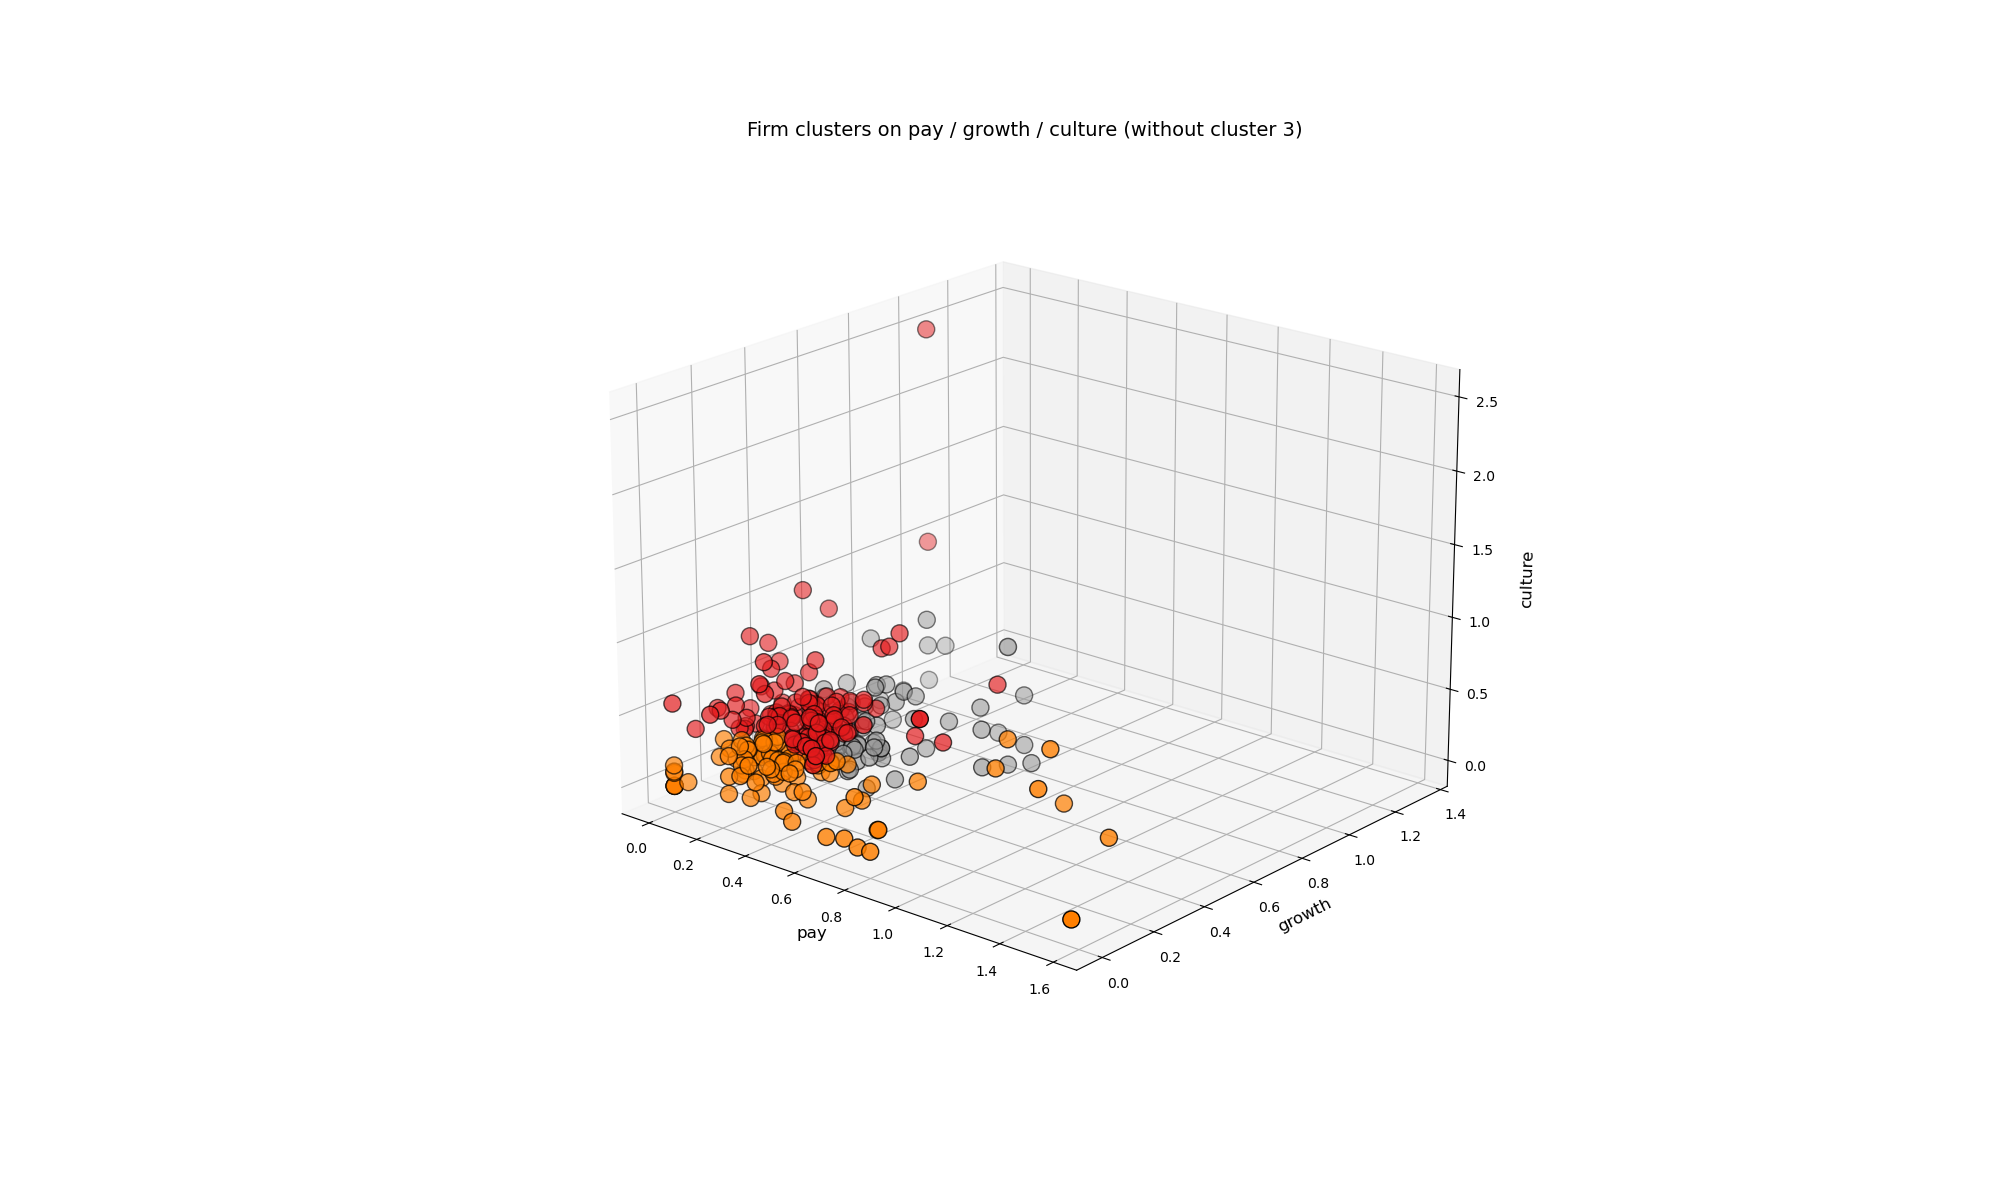

In [217]:
# Define the axes to plot
axes = ["pay", "growth", "culture"]

# Create a mask to filter out cluster 3
mask = labels != 3

# Filter the data and corresponding labels
xyz_filtered = X_sel.loc[mask, axes].values
filtered_labels = labels[mask]
filtered_labels_unique = np.unique(filtered_labels)
label_map = {old: i for i, old in enumerate(filtered_labels_unique)}
color_labels = np.vectorize(label_map.get)(filtered_labels)

# Define a custom colormap based on the number of remaining clusters
customcmap = cm.get_cmap("Set1", len(filtered_labels_unique))

# Plot the filtered data
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    xyz_filtered[:, 0], xyz_filtered[:, 1], xyz_filtered[:, 2],
    c=color_labels.astype(float),
    cmap=customcmap,
    s=150, edgecolor="k"
)
ax.set_xlabel("pay", fontsize=12)
ax.set_ylabel("growth", fontsize=12)
ax.set_zlabel("culture", fontsize=12, labelpad=10)
ax.view_init(20, -50)
ax.set_title("Firm clusters on pay / growth / culture (without cluster 3)", fontsize=14)
plt.show()